# Machine Learning Portfolio 3: Muziekgenres

- Teamnaam : Pitch perfect
- Teamleden : Daniella dijkdrent (23110112), Michelle Schijff (23111240), Alyssa Biesot (23140488), Syndey Nieuwenhuis (23130164)

#### Link github notebook:

In [1]:
# Importeren van de benodigde libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa as lr
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Audio, display, clear_output
import ipywidgets as widgets
from IPython.display import display as ipy_display
import soundfile as sf
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:

unlabeled = r"C:\Users\Miche\OneDrive\ML\Machine Learning Opdracht\portfolio 3\unlabeled"
labeled = r"C:\Users\Miche\OneDrive\ML\Machine Learning Opdracht\portfolio 3\labeled"

def load_data(directory):
    """
    Laad de data in van de gegeven directory
    
    Parameters:
    ----------
    directory: str
        De directory waar de data in staat
        
    Returns:
    -------
    data: list
        Een lijst van tuples met de filename, y en sr
    """
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            path = os.path.join(directory, filename)
            y, sr = lr.load(path)
            data.append((filename, y, sr))
    return data

unlabeled_data = load_data(unlabeled)
labeled_data = load_data(labeled)

unlabeled_df = pd.DataFrame(unlabeled_data, columns=["filename", "y", "sr"])
labeled_df = pd.DataFrame(labeled_data, columns=["filename", "y", "sr"])

In [3]:
# labels toevoegen aan de dataframe labeled_df
labels = pd.read_csv("labels_new.csv")
labeled_df = labeled_df.merge(labels, on="filename")
display(labeled_df.head())

,filename,y,sr,genre
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco


# 1. Feature engineering

In [4]:
def spectogram(df, n_fft=2048, hop_length=512, win_length=None):
    """
    Functie om de spectrogrammen van de audiofiles te berekenen
    
    Parameters:
    ----------
    audio: lijst 
        lijst met de audiofiles
    n_fft : integer
         aantal samples per frame
    hop_length : integer
         aantal samples tussen frames
    win_length : integer
         lengte van het raam

    Returns:
    -------
    spectrograms : lijst
         lijst met de spectrogrammen van de audiofiles
    """
    # Lege lijst om de features in op te slaan
    spectrograms = []
    spectrograms_db = []
    # Loop door de audiofiles
    for file, audio_data, sr in df:

            # Berekent de Short-Time Fourier Transform (STFT) van de audio data
            stft = lr.stft(audio_data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


            # Bereken de magnitude van de STFT
            magnitude = np.abs(stft)


            # Bereken de magnitude in decibels
            db = amplitude_to_db(magnitude)

            # Toevoegen van de spectrogram aan de lijst
            spectrograms.append(magnitude)

            # Toevoegen van de spectrogram in decibels aan de lijst
            spectrograms_db.append(db)

       
    return spectrograms, spectrograms_db

# Spectral bandwidth

In [5]:
def extract_bandwidth(spectograms):
    """
    Functie om de bandbreedte van de spectrogrammen te berekenen

    Parameters:
    ----------
    spectograms : lijst
         lijst met de spectrogrammen van de audiofiles

    Returns:
    -------
    bandwidth : lijst
         lijst met de bandbreedte van de spectrogrammen
    """
    # Lege lijst om de bandwidths in op te slaan
    bandwidth = []
    # Loop door de spectograms
    for spectogram in spectograms:
          band = lr.feature.spectral_bandwidth(S=spectogram)
          band = np.mean(band)
          bandwidth.append(band)        

     
     # Gemiddelde bandwith van de spectogrammen pakken?

    return bandwidth

In [6]:
# Bandwidth toevogen aan de dataframe

unlabeled_df_spectogram, unlabeled_df_spectogram_db = spectogram(unlabeled_data)
labeled_df_spectogram, labeled_df_spectogram_db = spectogram(labeled_data)

unlabeled_df["bandwidth"] = extract_bandwidth(unlabeled_df_spectogram)
labeled_df["bandwidth"] = extract_bandwidth(labeled_df_spectogram)

display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298


,filename,y,sr,genre,bandwidth
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548


## Uitleg van Spectral Bandwidth

De spectral bandwidth ook wel de spectral spread genoemd, is afgeleid van de spectral centroid (Agrawal, 2023). Het meet de spreiding van de frequenties vanaf de spectral centroid, het geeft niet alleen informatie over de spreiding van de frequenties maar ook over de breedte hiervan (Agrawal, 2023). 
Hierbij staat een hoge spectral bandwidth voor bredere frequenties, wat kan wijzen op meerdere tonen met ruis (Saranga-K-Mahanta-Google, 2021). Een lagere spectral bandwidth staat voor smallere frequenties en wijst op minder en weinig varieerende tonen in de audio (Saranga-K-Mahanta-Google, 2021).

In de wiskunde wordt de functie voor de spectral bandwidth als volgt gedefinieerd (Spectral Descriptors, n.d.):   

$
SB = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (f_i - \mu)^2}
$

Waar :
 - f_i, de frequentiecomponent is (Spectral Descriptors, n.d.)
 - mu, de spectral centroid is (Spectral Descriptors, n.d.)
 - N, het aantal frequenties is (Spectral Descriptors, n.d.)


Voor de spectral bandwidth in audio wordt de volgende formule gehanteerd (Librosa.Feature.Spectral_Bandwidth — Librosa 0.10.2.post1 Documentation, n.d.):   

$
SB = \frac{\sum_{i=1}^{N} |f_i| \cdot P(f_i)}{\sum_{i=1}^{N} P(f_i)}
$

Waar :
- f_i, de frequentiecomponent is
- P(f_i), de spectrale kracht is bij frequentie "f_i"

## Spectral flatness

In [7]:
def extract_flatness(spectograms):
    """
    Functie om de flatness van de spectrogrammen te berekenen

    Parameters:
    ----------
    spectograms : lijst
         lijst met de spectrogrammen van de audiofiles

    Returns:
    -------
    flatness : lijst
         lijst met de flatness van de spectrogrammen
    """
    # Lege lijst om de flatness in op te slaan
    flatness = []
    # Loop door de spectograms
    for spectogram in spectograms:
          flat = (lr.feature.spectral_flatness(S=spectogram))
          flat = np.mean(flat)
          flatness.append(flat)
          
    return flatness

In [8]:
unlabeled_df["flatness"] = extract_flatness(unlabeled_df_spectogram)
labeled_df["flatness"] = extract_flatness(labeled_df_spectogram)

display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153


,filename,y,sr,genre,bandwidth,flatness
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791


## uitleg van Spectral Flatness:
Dit is een maatstaf die aangeeft hoe vlak of ruisachtig het geluidsignaal is, het word daarom ook wel de "tonality coefficient" genoemd (Agrawal, 2023). Een hoge spectral flatness (dicht bij 1) geeft aan dat er veel verschillende frequencies in het signaal voorkomen, ook wel ruis genoemd (Agrawal, 2023) (Librosa.Feature.Spectral_Flatness — Librosa 0.10.2.post1 Documentation, n.d.). Een lage spectral flatness (dicht bij 0) geeft juist aan dat er maar een paar frequencies zijn die sterk voorkomen in het signaal.

Voorbeelden voor een hoge spectral flatness zijn nummers met veel drums erin, er zullen namelijk weinig sterke frequenties in voorkomen (Agrawal, 2023). Voor lage spectral flatness zijn fluit of piano nummers een goed voorbeeld, deze instrumenten geven een zuivere en duidelijke toon af. Deze nummers zullen dan ook weinig ruis bevatten en een lagere spectral frequentie hebben.

De wiskundige formule van spectral flatness gaat als volgt (Spectral Descriptors, n.d.):

$
{Spectral Flatness} = \frac{\sqrt[N]{\prod_{n=0}^{N-1} P(f_n)}}{\frac{1}{N} \sum_{n=0}^{N-1} P(f_n)}
$

Waar :
- P(f_n), de spectrale kracht is (Spectral Descriptors, n.d.)
- N, het aantal frequenties is (Spectral Descriptors, n.d.)

De formule in woorden is: De verhouding van het geometrisch gemiddelde tot het rekenkundig gemiddelde van het machtsspectrum van het geluidssignaal (Agrawal, 2023).



## Mel Frequency Cepstral Coefficients (MFCCs)

In [9]:
def mel_frequency_cepstral_coefficients(spectograms, n_mfcc=13):
    """
    Functie om de Mel-frequency cepstral coefficients (MFCCs) van de spectrogrammen te berekenen

    Parameters:
    ----------
    spectograms : lijst
         lijst met de spectrogrammen van de audiofiles
    n_mfcc : integer
         aantal MFCCs

    Returns:
    -------
    mfccs : lijst
         lijst met de MFCCs van de spectrogrammen
    """
    # Lege lijst om de MFCCs in op te slaan
    mfccs = []

    # Loop door de spectograms
    for spectogram in spectograms:
        mfcc = lr.feature.mfcc(S=spectogram, n_mfcc=n_mfcc)
        mfccs.append(mfcc)
        
    return mfccs

In [10]:
unlabeled_df["mfcc"] = mel_frequency_cepstral_coefficients(unlabeled_df_spectogram)
labeled_df["mfcc"] = mel_frequency_cepstral_coefficients(labeled_df_spectogram)

display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness,mfcc
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,"[[29.240292, 36.948692, 62.071255, 95.03323, 8..."
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,"[[57.37244, 76.644844, 75.79672, 70.71866, 69...."
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,"[[4.6971264, 8.0897045, 9.708591, 9.01828, 6.9..."
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,"[[22.633875, 27.187572, 23.690687, 31.765917, ..."
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,"[[2.3547761, 2.3440263, 2.038974, 2.0077922, 1..."


,filename,y,sr,genre,bandwidth,flatness,mfcc
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,"[[10.088685, 11.17814, 14.838247, 13.311733, 1..."
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,"[[12.500576, 11.80151, 11.088381, 10.681015, 9..."
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,"[[74.86608, 100.393, 91.74253, 79.10695, 58.92..."
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,"[[18.976692, 37.019646, 43.088326, 35.626854, ..."
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,"[[40.140728, 91.55816, 105.914345, 89.75652, 7..."


In [11]:
# 12 kolommen met de MFCCs toevoegen aan de dataframe
for i in range(13):
    unlabeled_df[f"mfcc_{i}"] = unlabeled_df["mfcc"].apply(lambda x: np.mean(x[i]))
    labeled_df[f"mfcc_{i}"] = labeled_df["mfcc"].apply(lambda x: np.mean(x[i]))

unlabeled_df.drop(columns=["mfcc"], inplace=True)
labeled_df.drop(columns=["mfcc"], inplace=True)

display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,12.823794,16.958540,17.825361,17.966415,15.737244,13.305872,10.406915,8.733800
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,22.899349,24.621336,18.030006,15.613467,15.113979,17.945738,15.389009,9.667322
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,0.879241,1.083423,1.091666,1.022341,0.871147,0.742825,0.502857,0.211371
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,7.527008,11.965754,13.468820,13.765881,12.013191,9.963724,8.565038,7.967763
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,1.956533,1.500664,1.095757,0.736699,0.426034,0.159925,-0.067385,-0.252988


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,5.370150,4.490129,3.799163,3.025623,2.466176,1.866513,1.439481,1.171063,0.898786
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,13.483004,11.860577,10.872185,10.263906,10.684957,10.200386,10.194226,9.626275,8.025516
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,18.914400,10.673307,8.669869,5.702235,3.198745,2.746982,2.987776,0.854162,0.521695
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,10.912189,7.716510,6.320828,6.135101,4.445561,3.863496,2.983674,2.581895,3.451405
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,20.355610,18.852934,16.744081,10.967149,11.066016,9.123006,7.445765,7.461009,6.716366


## uitleg van de mel-frequency cepstral coefficients:

We kijken allereerst naar de naam Mel-Frequency Cepstral Coefficients zelf:
- Mel-frequency, hiermee word verwezen naar **de mel-scale** is een schaal die reflecteert hoe mensen muziektonen horen. Hoe mensen geluidstonen binnen krijgen is niet lineair, dit wil zeggen dat de mens makkelijker onderscheid maakt tussen lage tonen dan in hogere tonen (Chourasia, 2025). De mel-scale zorgt ervoor dat de afstanden tussen de verschillende frequenties die de mens kan horen hetzelfde is, en maakt van de normale lineaire frequentie schaal een non-lineaire schaal (Chourasia, 2025). De formule om de frequentie op de mel schaal te zetten gaat als volgt (Wikipedia contributors, 2024):  
$
m = 2595 \log_{10} \left( 1 + \frac{f}{700} \right)
$

Hierbij is 'f' de frequentie gemeten in Hertz.

- Cepstral coefficients, dit zijn numerieke waarden die de spectrumvorm van een signaal omschrijven. De berekening van de cepstral coefficients bestaat uit vier stappen.
    - **stap 1:** Het omzetten van een tijdsignaal naar een frequentiesignaal door middel van de discrete fourier transformatie (Za’ter, 2022).
    - **stap 2:** Toepassen van de mel filterbank, deze **driehoekvormige filter** zorgt ervoor dat de frequenties tot de 1000 Hertz lineair zijn in afstand tot elkaar. Na de 1000 Hertz zal de afstand logaritmisch zijn (Za’ter, 2022).
    - **stap 3:** De logaritme van de filterbank word genomen, hierdoor worden de frequenties omgezet naar signalen die nabootsen hoe de mens het hoort (Za’ter, 2022).
    - **stap 4:** de inverse discrete fourier transformatie pakken, hiermee krijg je de cepstrum (Za’ter, 2022).


Het volledige stappenplan om de **mel frequency cepstral coefficients** te krijgen gaat als volgt:
- **stap 1:** pre-emphasizing the signal, hier word mee bedoeld dat het signaal van de hogere frequenties groter gemaakt word om het spectrum een betere balans te geven (GeeksforGeeks, 2024).
- **stap 2:** framing, het signaal opbreken in kleine overlappende stukjes om een accurate representatie van de data te krijgen (GeeksforGeeks, 2024).
- **stap 3:** windowing, het signaal opbreken in sliding frames door middel van **de hamming window** om de randen van de signalen te verzachten en het einde minder abrupt te maken (GeeksforGeeks, 2024).
- **stap 4:** Het omzetten van een tijdsignaal naar een frequentiesignaal door middel van de discrete fourier transformatie (GeeksforGeeks, 2024).
- **stap 5:** Toepassen van de mel filterbank, deze driehoekvormige filter zorgt ervoor dat de frequenties tot de 1000 Hertz **lineair** zijn in afstand tot elkaar. Na de 1000 Hertz zal de afstand **logaritmisch** zijn (Za’ter, 2022).
- **stap 6:** De logaritme van de filterbank word genomen, hierdoor worden de frequenties omgezet naar signalen die nabootsen hoe de mens het hoort (Za’ter, 2022).
- **stap 7:** de inverse discrete fourier transformatie pakken, hiermee krijg je de cepstrum. Hier worden de **N aantal coefficienten** van gepakt, dit zijn er vaak **12** voor de 12 tonen die de mens kan onderscheiden (Za’ter, 2022).

De coefficienten die er bij stap 7 uitkomen zijn de features van de mel-frequency cepstral coefficients.

## BPM

In [12]:
#BPM berekenen
def bpm(y, sr):
    onset_env = lr.onset.onset_strength(y=y, sr=sr)
    tempo = lr.beat.tempo(onset_envelope=onset_env, sr=sr)
    return tempo

#code bron: (librosa.feature.tempo — Librosa 0.10.2 Documentation, n.d.)


In [13]:

unlabeled_df["bpm"] = unlabeled_df.apply(lambda row: bpm(row["y"], row["sr"]), axis=1)
labeled_df["bpm"] = labeled_df.apply(lambda row: bpm(row["y"], row["sr"]), axis=1)

display(unlabeled_df.head())
display(labeled_df.head())

C:\Users\Miche\AppData\Local\Temp\ipykernel_14548\1687544189.py:4: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = lr.beat.tempo(onset_envelope=onset_env, sr=sr)
C:\Users\Miche\AppData\Local\Temp\ipykernel_14548\1687544189.py:4: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = lr.beat.tempo(onset_envelope=onset_env, sr=sr)


,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,12.823794,16.958540,17.825361,17.966415,15.737244,13.305872,10.406915,8.733800,[135.99917763157896]
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,22.899349,24.621336,18.030006,15.613467,15.113979,17.945738,15.389009,9.667322,[103.359375]
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,0.879241,1.083423,1.091666,1.022341,0.871147,0.742825,0.502857,0.211371,[95.703125]
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,7.527008,11.965754,13.468820,13.765881,12.013191,9.963724,8.565038,7.967763,[135.99917763157896]
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,1.956533,1.500664,1.095757,0.736699,0.426034,0.159925,-0.067385,-0.252988,[107.666015625]


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,5.370150,4.490129,3.799163,3.025623,2.466176,1.866513,1.439481,1.171063,0.898786,[129.19921875]
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,13.483004,11.860577,10.872185,10.263906,10.684957,10.200386,10.194226,9.626275,8.025516,[135.99917763157896]
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,18.914400,10.673307,8.669869,5.702235,3.198745,2.746982,2.987776,0.854162,0.521695,[95.703125]
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,10.912189,7.716510,6.320828,6.135101,4.445561,3.863496,2.983674,2.581895,3.451405,[129.19921875]
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,20.355610,18.852934,16.744081,10.967149,11.066016,9.123006,7.445765,7.461009,6.716366,[123.046875]


## Uitleg van BPM:

BPM staat voor Beats Per Minute. Dit geeft aan hoeveel beats een nummer bevat per minuut, En wordt gebruikt om de tempo van een nummer te meten. Deze eigenschap bepaalt de snelheid van een muziekstuk en speelt een cruciale rol bij genres en dansritmes


Formule:

$$
\text{BPM} = \frac{60}{\text{Interval tussen beats in seconden}}
$$

interval tussen beats in seconden: de tijd tussen twee opeenvolgende beats.

Beats Per Minute wordt berekend door het interval tussen de Beats te delen door een minuut. 

Voordat de BPM kan worden berekend moet eerst het interval tussen de beats worden gevonden dit kan worden gedaan door deze formule:

$$
\Delta t = t_{i+1} - t_i
$$

interpretatie 
kenmerkend BPM-bereik verschillende muziekgenres
- langzaam (60-90 BPM): Ballads, jazz
- Gemiddeld (90 - 120 BPM): Pop, hiphop
- Snel (120-160 BPM): EDM, techno
- Zeer snel (>160 BPM): Hardcore, drum & bass


## Spectral centroid

In [14]:
#spectral centroid berekenen
def spectral_centroid(y, sr):
    centroid = lr.feature.spectral_centroid(y=y, sr=sr)
    return np.mean(centroid)

In [15]:
unlabeled_df["spectral_centroid"] = unlabeled_df.apply(lambda row: spectral_centroid(row["y"], row["sr"]), axis=1)
labeled_df["spectral_centroid"] = labeled_df.apply(lambda row: spectral_centroid(row["y"], row["sr"]), axis=1)

display(unlabeled_df.head())
display(labeled_df.head())

#code bron: (Librosa.Feature.Spectral_Centroid — Librosa 0.10.2 Documentation, n.d.)

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,12.823794,16.958540,17.825361,17.966415,15.737244,13.305872,10.406915,8.733800,[135.99917763157896],2254.606986
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,22.899349,24.621336,18.030006,15.613467,15.113979,17.945738,15.389009,9.667322,[103.359375],2908.300131
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,0.879241,1.083423,1.091666,1.022341,0.871147,0.742825,0.502857,0.211371,[95.703125],1952.607933
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,7.527008,11.965754,13.468820,13.765881,12.013191,9.963724,8.565038,7.967763,[135.99917763157896],2384.634958
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,1.956533,1.500664,1.095757,0.736699,0.426034,0.159925,-0.067385,-0.252988,[107.666015625],790.507005


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,...,4.490129,3.799163,3.025623,2.466176,1.866513,1.439481,1.171063,0.898786,[129.19921875],1451.862124
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,...,11.860577,10.872185,10.263906,10.684957,10.200386,10.194226,9.626275,8.025516,[135.99917763157896],1811.410394
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,...,10.673307,8.669869,5.702235,3.198745,2.746982,2.987776,0.854162,0.521695,[95.703125],3110.898196
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,...,7.716510,6.320828,6.135101,4.445561,3.863496,2.983674,2.581895,3.451405,[129.19921875],2624.814629
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,...,18.852934,16.744081,10.967149,11.066016,9.123006,7.445765,7.461009,6.716366,[123.046875],2549.269757


## Uitleg van spectral centroid:
Spectral features zijn zeer belangrijk voor het analyseren en begrijpen van signalen. 

De Spectral Centroid representeert het zwaartepunt van het audio spectrum en laat de gemiddelde frequentie op dat moment. Dit kan inzicht brengen in toonhoogte of gebruikte instrumenten.

formule Spectral Centroid:

$$
\text{centroid}[t] = \frac{\sum_k S[k, t] \cdot \text{freq}[k]}{\sum_j S[j, t]}
$$

- centroid[t]: Spectral Centroid op tijdstip t. De gemiddelde frequentie op dat moment.
- S[k,t]: De amplitude van de frequentie k op tijdstip t. Dit wordt vaak gehaald uit het spectrogram
- freq[k]: de frequentie van de waarde k
- $ \sum_k S[k, t] \cdot \text{freq}[k] $ : geeft een gewogen som van de S[k, t] waarden, waarbij elke waarde wordt vermenigdvuldigd met de bijhoorende frequentie k.
- $ \sum_j S[j, t] $ : de som van de waarden van alle amplitudes. Dit normaliseert de gewogen som, zodat de Spectral Centroid een gemiddelde frequentie weergeeft. (Librosa.Feature.Spectral_Centroid — Librosa 0.10.2.post1 Documentation, n.d.)

Interpretatie van Spectral Centroid
- Hoge Centroid-waarden: Geassocieerd met geluiden met meer energie in het hogere frequentiespectrum
- Lage Centroid-waarden: Geluiden met meer energie in het lagere frequentiespectrum.



## Spectral contrast

In [16]:
#spectral contrast berekenen
def spectral_contrast(y, sr):
    contrast = lr.feature.spectral_contrast(y=y, sr=sr)
    return np.mean(contrast)

In [17]:
unlabeled_df["spectral_contrast"] = unlabeled_df.apply(lambda row: spectral_contrast(row["y"], row["sr"]), axis=1)
labeled_df["spectral_contrast"] = labeled_df.apply(lambda row: spectral_contrast(row["y"], row["sr"]), axis=1)


display(unlabeled_df.head())
display(labeled_df.head())

#code bron: (Librosa.Feature.Spectral_Contrast — Librosa 0.10.2 Documentation, n.d.)

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,...,16.958540,17.825361,17.966415,15.737244,13.305872,10.406915,8.733800,[135.99917763157896],2254.606986,20.380788
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,...,24.621336,18.030006,15.613467,15.113979,17.945738,15.389009,9.667322,[103.359375],2908.300131,20.044021
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,...,1.083423,1.091666,1.022341,0.871147,0.742825,0.502857,0.211371,[95.703125],1952.607933,23.250822
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,...,11.965754,13.468820,13.765881,12.013191,9.963724,8.565038,7.967763,[135.99917763157896],2384.634958,19.720750
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,...,1.500664,1.095757,0.736699,0.426034,0.159925,-0.067385,-0.252988,[107.666015625],790.507005,20.252849


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,...,3.799163,3.025623,2.466176,1.866513,1.439481,1.171063,0.898786,[129.19921875],1451.862124,24.220021
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,...,10.872185,10.263906,10.684957,10.200386,10.194226,9.626275,8.025516,[135.99917763157896],1811.410394,22.125983
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,...,8.669869,5.702235,3.198745,2.746982,2.987776,0.854162,0.521695,[95.703125],3110.898196,17.236284
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,...,6.320828,6.135101,4.445561,3.863496,2.983674,2.581895,3.451405,[129.19921875],2624.814629,19.451050
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,...,16.744081,10.967149,11.066016,9.123006,7.445765,7.461009,6.716366,[123.046875],2549.269757,21.878422


## Spectral contrast uitleg

Spectral Contrast is een audiofeature dat wordt gebruikt in signaalverwerking en machine learning voor audioanalyse.

Het meet het verschil (contrast) tussen de energie van pieken (maxima) en dalen (minima) in het frequentiespectrum van een audiosignaal. 

$$ C_k = 10 \cdot \log_{10} \left( \frac{P_k}{N_k} \right) $$

- $ P_k $: De gemiddelde energie van de pieken in frequentieband k
- $ N_k $: De gemiddelde energie van de dalen in frequentieband k


## zero crossing rate

In [18]:
# Zero Crossing Rate berekenen
def zero_crossing_rate(y):
    """
    Berekent de Zero Crossing Rate (ZCR) van een audiosignaal.
    
    Parameters:
    - y: numpy array van het audiosignaal
    
    Returns:
    - ZCR: Gemiddelde Zero Crossing Rate (per frame)
    """
    return lr.feature.zero_crossing_rate(y=y)[0]

In [19]:
unlabeled_df["zero_crossing_rate"] = unlabeled_df.apply(lambda row: zero_crossing_rate(row["y"]).mean(), axis=1)
labeled_df["zero_crossing_rate"] = labeled_df.apply(lambda row: zero_crossing_rate(row["y"]).mean(), axis=1)

# Resultaten
display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,...,17.825361,17.966415,15.737244,13.305872,10.406915,8.733800,[135.99917763157896],2254.606986,20.380788,0.120116
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,...,18.030006,15.613467,15.113979,17.945738,15.389009,9.667322,[103.359375],2908.300131,20.044021,0.178108
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,...,1.091666,1.022341,0.871147,0.742825,0.502857,0.211371,[95.703125],1952.607933,23.250822,0.123423
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,...,13.468820,13.765881,12.013191,9.963724,8.565038,7.967763,[135.99917763157896],2384.634958,19.720750,0.126073
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,...,1.095757,0.736699,0.426034,0.159925,-0.067385,-0.252988,[107.666015625],790.507005,20.252849,0.052088


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,...,3.025623,2.466176,1.866513,1.439481,1.171063,0.898786,[129.19921875],1451.862124,24.220021,0.051224
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,...,10.263906,10.684957,10.200386,10.194226,9.626275,8.025516,[135.99917763157896],1811.410394,22.125983,0.072150
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,...,5.702235,3.198745,2.746982,2.987776,0.854162,0.521695,[95.703125],3110.898196,17.236284,0.152857
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,...,6.135101,4.445561,3.863496,2.983674,2.581895,3.451405,[129.19921875],2624.814629,19.451050,0.120217
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,...,10.967149,11.066016,9.123006,7.445765,7.461009,6.716366,[123.046875],2549.269757,21.878422,0.115834


## Uitleg zero crossing rate
### Algemene uitleg begrip
De *Zero Crossing Rate (ZCR)* is een veelgebruikte audiokenmerk in signaalverwerking. het meet hoe vaak het signaal de nul as kruist. dit kan van positief naar negatief of andersom en dan binnen een bepaald tijdvenster (3.11. Zero-crossing Rate — Introduction to Speech Processing, n.d.).

- Bij ruis achtig geluid, zoals metal of drums, is de scr hoger omdat het signaal snel veranderd (3.11. Zero-crossing Rate — Introduction to Speech Processing, n.d.).
- Bij gladde geluiden, zoals jazz of klassieke muziek, is de zcr lager omdat het signal meer consistent is (3.11. Zero-crossing Rate — Introduction to Speech Processing, n.d.). 

De ZCR wordt vaak gebruikt in (3.11. Zero-crossing Rate — Introduction to Speech Processing, n.d.):
1. Spraakherkenning: om spraak van stilte te onderscheiden.
2. Muziekgenreclassificatie: om stijlen met verschillende frequentie patronen te herkennen.
3. Detectie van toonhoogte of ruis: Om geluiden met verschillende dynamieken te analyseren.

---

### Uitleg zonder formules
1. Vensteranalyse:
   De ZCR wordt berekend binnen kleine overlappende vensters in het signaal. dit zorgt voor dat de zcr lokaal en dynamisch word berekend (Wikipedia contributors, 2021). 

2. Overgangen tellen:
   Voor elk venster word gekeken naar de twee samples achter elkaar in het signaal. als het teken van signaal veranderd telt dat als een zero crossing (Wikipedia contributors, 2021).
3. Normalisatie:
   De totale zero crossing binnen een venster worden gedeeld door  aantal samples in dat venster om een gemiddelde ZCR te berekenen (Wikipedia contributors, 2021).

4. Praktische interpretatie (Wikipedia contributors, 2021):
   - Hoge ZCR: snelle fluctuaties (zoals ruis, percussie, of scherpe tonen).
   - Lage ZCR: langzamere fluctuaties of is meer continu (zoals zang, strijkinstrumenten, of basgeluiden).


## Amplitude Envelope 

In [20]:
def amplitude_envelope(y, frame_size=1024, hop_length=512):
    """
    Berekent de amplitude envelope van een audiosignaal.
    
    Parameters:
    - y: numpy array van het audiosignaal
    - frame_size: grootte van elk frame (standaard: 1024)
    - hop_length: stapgrootte tussen frames (standaard: 512)
    
    Returns:
    - envelope: de gemiddelde amplitude envelope
    """
    #reshaped het signaal in frames
    return np.array([
        np.max(np.abs(y[i:i + frame_size])) 
        for i in range(0, len(y), hop_length)
    ])

In [21]:

#Amplitude envelope toevoegen 
unlabeled_df["amplitude_envelope"] = unlabeled_df.apply(lambda row: amplitude_envelope(row["y"]).mean(), axis=1)
labeled_df["amplitude_envelope"] = labeled_df.apply(lambda row: amplitude_envelope(row["y"]).mean(), axis=1)

#resultaat
display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,...,17.966415,15.737244,13.305872,10.406915,8.733800,[135.99917763157896],2254.606986,20.380788,0.120116,0.413478
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,...,15.613467,15.113979,17.945738,15.389009,9.667322,[103.359375],2908.300131,20.044021,0.178108,0.715745
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,...,1.022341,0.871147,0.742825,0.502857,0.211371,[95.703125],1952.607933,23.250822,0.123423,0.089076
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,...,13.765881,12.013191,9.963724,8.565038,7.967763,[135.99917763157896],2384.634958,19.720750,0.126073,0.314808
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,...,0.736699,0.426034,0.159925,-0.067385,-0.252988,[107.666015625],790.507005,20.252849,0.052088,0.048906


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,...,2.466176,1.866513,1.439481,1.171063,0.898786,[129.19921875],1451.862124,24.220021,0.051224,0.130842
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,...,10.684957,10.200386,10.194226,9.626275,8.025516,[135.99917763157896],1811.410394,22.125983,0.072150,0.345269
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,...,3.198745,2.746982,2.987776,0.854162,0.521695,[95.703125],3110.898196,17.236284,0.152857,0.608007
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,...,4.445561,3.863496,2.983674,2.581895,3.451405,[129.19921875],2624.814629,19.451050,0.120217,0.437070
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,...,11.066016,9.123006,7.445765,7.461009,6.716366,[123.046875],2549.269757,21.878422,0.115834,0.499480


## Uitleg amplitude envelope
### Algemene uitleg begrip
De amplitude envelope is een audiokenmerk dat de variatie in volume van een audiosignaal over een bepaalde tijd beschrijft 
(Amplitude Envelope — Music Information Retrieval). 
Het meet de maximale amplitude binnen kleine frames van het audiosignaal 
(Amplitude Envelope — Music Information Retrieval). 

- Bij dynamische muziekstijlen zoals metal of rock is de amplitude envelope vaak hoog vanwege de variatie van de luidheid.
- Bij rustigere stukken muziek zoals jazz of klassieke muziek is de amplitude envelope vaak lager en constanter.

Toepassingen van de amplitude envelope 
(Amplitude Envelope — Music Information Retrieval):
1. Spraak- en muzieksegmentatie: Onderscheid  tussen luidere en zachtere delen.
2. Muziekgenreclassificatie: Patronen in volumevariatie goed analyseren.
3. Effectverwerking:Gebruikt in audioversterking en compressie


### Uitleg van de code
de functie amplitude_envelope berekent de amplitude envelope door elke frame van het signaal te analyseren dit gebruikt op de volgende manier: 
1. Inputparameters 
(Amplitude Envelope — Music Information Retrieval):
   - y: Het audiosignaal, een numpy-array van amplitudes.
   - frame_size:De grootte van elk frame waarin de amplitude wordt gemeten (standaard 1024 samples).
   - hop_length:de sprong tussen frames (standaard 512 samples).

2. Berekening 
(Amplitude Envelope — Music Information Retrieval):
   - Het audiosignaal wordt opgedeeld in overlappende frames.
   - Voor elk frame wordt de maximale absolute amplitude berekend. Dit geeft de luidste piek binnen dat frame.
   - De resultaten worden samengevoegd tot een array van maximale amplitudes per frame.

3. Gemiddelde amplitude envelope 
(Amplitude Envelope — Music Information Retrieval):
   - De gemiddelde waarde van de maximale amplitudes in alle frames wordt berekend en toegevoegd als een kenmerk aan zowel unlabeled_df als labeled_df.

4. Resultaat
(Amplitude Envelope — Music Information Retrieval):
   - Een nieuwe kolom amplitude_envelope wordt toegevoegd aan de dataframes, met een numerieke waarde die de gemiddelde luidheid van het signaal vertegenwoordigt.


### Interpretatie van de output
1. Hoge amplitude envelope 
(Amplitude Envelope — Music Information Retrieval):
   - Bijvoorbeeld m00228.wav amplitude envelope van 0.637. Dit duidt op een dynamisch en luid audiosignaal.
2. Lage amplitude envelope 
(Amplitude Envelope — Music Information Retrieval):
   - Bijvoorbeeld m00348.wav waarde van 0.173. Dit laat zien een rustiger of zachter signaal.
3. Relatie met andere kenmerken 
(Amplitude Envelope — Music Information Retrieval):
   - Signalen met een hogere amplitude envelope hebben vaak  een hogere spectral_centroid, wat weer wijst op een dominantie van hogere frequenties.
   - Signalen met een lagere amplitude envelope hebben een lagere zero_crossing_rate, wat duidt op minder fluctuaties in het signaal.


### Praktische interpretatie
De amplitude envelope is een belangrijk kenmerk om dynamiek en luidheid in muziek of spraak te analyseren. zo kan het bijvoorbeeld helpen om genres te onderscheiden, waarbij volumevariatie een belangrijke rol is.


## Spectral Flux

In [22]:
# Spectral flux berekenen
def spectral_flux(y, sr):
    """
    Bereken de spectral flux van een audio-opname.
    """
    spectral_centroids = lr.feature.spectral_centroid(y=y, sr=sr)
    return np.mean(np.diff(spectral_centroids, axis=1)) 

In [23]:
unlabeled_df["spectral_flux"] = unlabeled_df.apply(lambda row: spectral_flux(row["y"], row["sr"]), axis=1)
labeled_df["spectral_flux"] = labeled_df.apply(lambda row: spectral_flux(row["y"], row["sr"]), axis=1)

display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,...,15.737244,13.305872,10.406915,8.733800,[135.99917763157896],2254.606986,20.380788,0.120116,0.413478,0.231618
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,...,15.113979,17.945738,15.389009,9.667322,[103.359375],2908.300131,20.044021,0.178108,0.715745,0.222149
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,...,0.871147,0.742825,0.502857,0.211371,[95.703125],1952.607933,23.250822,0.123423,0.089076,-0.164084
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,...,12.013191,9.963724,8.565038,7.967763,[135.99917763157896],2384.634958,19.720750,0.126073,0.314808,0.112204
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,...,0.426034,0.159925,-0.067385,-0.252988,[107.666015625],790.507005,20.252849,0.052088,0.048906,-0.334935


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_9,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,...,1.866513,1.439481,1.171063,0.898786,[129.19921875],1451.862124,24.220021,0.051224,0.130842,0.560904
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,...,10.200386,10.194226,9.626275,8.025516,[135.99917763157896],1811.410394,22.125983,0.072150,0.345269,0.477917
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,...,2.746982,2.987776,0.854162,0.521695,[95.703125],3110.898196,17.236284,0.152857,0.608007,-0.201019
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,...,3.863496,2.983674,2.581895,3.451405,[129.19921875],2624.814629,19.451050,0.120217,0.437070,0.281160
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,...,9.123006,7.445765,7.461009,6.716366,[123.046875],2549.269757,21.878422,0.115834,0.499480,-0.166238


## Uitleg Spectral Flux
Spectral Flux meet de verandering in de frequentie-inhoud van het geluid. Het kijkt niet naar de luidheid, maar naar hoe plotseling frequenties veranderen (Wikipedia contributors, 2022).

- Een hoge Spectral Flux betekent dat er grote veranderingen zijn in de frequenties, zoals wanneer een drum plotseling klinkt of een instrument abrupt van toonhoogte verandert.
- Een lage Spectral Flux betekent dat het geluid relatief stabiel is, zonder veel plotselinge veranderingen.

Belangrijke kenmerken (ScienceDirect, 2016):

- Spectral Flux is vooral gevoelig voor dynamische veranderingen in het geluid, zoals percussieve geluiden (bijvoorbeeld drumslagen) of plotselinge transities tussen noten of akkoorden. Dit maakt het een nuttige maatstaf om transities en ritmische elementen in een audiobestand te identificeren.
- Normalisatie van de spectrale waarden is vaak nodig om de verschillen in amplitude te compenseren. Zonder normalisatie zouden luide geluiden de flux domineren, waardoor zachte maar significante frequentiewijzigingen minder zichtbaar worden.

Berekening: Spectral Flux wordt berekend door het verschil in spectrale energie tussen twee opeenvolgende frames te vergelijken (MathWorks, 1997):

$$
\text{SpectralFlux} = \sum_j \left( |S_t(j)| - |S_{t-1}(j)| \right)^2
$$

Waarbij:
- `S_t(j)`: De spectrale energie in het huidige frame \( t \) bij frequentie \( j \).
- `S_{t-1}(j)`: De spectrale energie in het vorige frame \( t-1 \) bij dezelfde frequentie \( j \).
- De som loopt over alle frequentie-indexen \( j \).

## Root mean square energy

In [24]:
# RMS berekenen
def rms_energy(y, sr):
    """
    Bereken de root mean square (RMS) energy van een audio-opname.
    """
    return np.mean(lr.feature.rms(y=y))  # Gemiddelde RMS over tijd


In [25]:
unlabeled_df["rms_energy"] = unlabeled_df.apply(lambda row: rms_energy(row["y"], row["sr"]), axis=1)
labeled_df["rms_energy"] = labeled_df.apply(lambda row: rms_energy(row["y"], row["sr"]), axis=1)

display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,...,13.305872,10.406915,8.733800,[135.99917763157896],2254.606986,20.380788,0.120116,0.413478,0.231618,0.136221
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,...,17.945738,15.389009,9.667322,[103.359375],2908.300131,20.044021,0.178108,0.715745,0.222149,0.217475
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,...,0.742825,0.502857,0.211371,[95.703125],1952.607933,23.250822,0.123423,0.089076,-0.164084,0.029083
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,...,9.963724,8.565038,7.967763,[135.99917763157896],2384.634958,19.720750,0.126073,0.314808,0.112204,0.100411
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,...,0.159925,-0.067385,-0.252988,[107.666015625],790.507005,20.252849,0.052088,0.048906,-0.334935,0.018833


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_10,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,...,1.439481,1.171063,0.898786,[129.19921875],1451.862124,24.220021,0.051224,0.130842,0.560904,0.050480
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,...,10.194226,9.626275,8.025516,[135.99917763157896],1811.410394,22.125983,0.072150,0.345269,0.477917,0.123665
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,...,2.987776,0.854162,0.521695,[95.703125],3110.898196,17.236284,0.152857,0.608007,-0.201019,0.198322
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,...,2.983674,2.581895,3.451405,[129.19921875],2624.814629,19.451050,0.120217,0.437070,0.281160,0.142927
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,...,7.445765,7.461009,6.716366,[123.046875],2549.269757,21.878422,0.115834,0.499480,-0.166238,0.184340


## Uitleg root mean square energy
RMS Energy meet de gemiddelde energie (luidheid) van het geluid in een tijdsframe. Het kijkt naar hoe "krachtig" het signaal is, ongeacht hoe de frequenties veranderen (Agrawal, 2023).
- Een hoge RMS Energy geeft aan dat het geluid luider is.
- Een lage RMS Energy betekent dat het geluid zachter is of zelfs stil.

Berekening: RMS Energy wordt berekend door het kwadraat van de amplitudes in een tijdsframe te middelen en daar de vierkantswortel van te nemen (Energy, n.d.):

$$
\text{RMSEnergy} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x[i]^2}
$$

Hierbij is 
𝑥[𝑖] de amplitude van het signaal en 𝑁 het aantal samples.

## Band energy ratio

In [26]:
# Band energy ratio (BER) berekenen
def band_energy_ratio(y, sr):
    """
    Bereken de band energy ratio (BER) van een audio-opname.
    """
    total_energy = np.sum(np.abs(y) ** 2)  # Totale energie
    low_energy = np.sum(np.abs(y[: len(y) // 2]) ** 2)  # Energie in eerste helft
    return low_energy / total_energy if total_energy > 0 else 0

In [27]:
unlabeled_df["band_energy_ratio"] = unlabeled_df.apply(lambda row: band_energy_ratio(row["y"], row["sr"]), axis=1)
labeled_df["band_energy_ratio"] = labeled_df.apply(lambda row: band_energy_ratio(row["y"], row["sr"]), axis=1)

display(unlabeled_df.head())
display(labeled_df.head())

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,2071.028440,0.009073,48.213165,46.236736,20.156157,11.940553,8.146311,...,10.406915,8.733800,[135.99917763157896],2254.606986,20.380788,0.120116,0.413478,0.231618,0.136221,0.497855
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,2286.252592,0.026373,96.537567,75.530022,14.533386,10.292311,12.471623,...,15.389009,9.667322,[103.359375],2908.300131,20.044021,0.178108,0.715745,0.222149,0.217475,0.531037
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,1865.996047,0.002211,7.502871,7.726105,3.876972,2.249571,1.130098,...,0.502857,0.211371,[95.703125],1952.607933,23.250822,0.123423,0.089076,-0.164084,0.029083,0.463700
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,2072.759900,0.008830,35.285793,32.211994,11.328982,6.129344,3.947284,...,8.565038,7.967763,[135.99917763157896],2384.634958,19.720750,0.126073,0.314808,0.112204,0.100411,0.475435
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,900.409298,0.000153,2.865129,3.846751,3.435098,2.951071,2.449761,...,-0.067385,-0.252988,[107.666015625],790.507005,20.252849,0.052088,0.048906,-0.334935,0.018833,0.763686


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,1920.270843,0.001261,7.614994,8.841931,7.031066,6.608410,...,1.171063,0.898786,[129.19921875],1451.862124,24.220021,0.051224,0.130842,0.560904,0.050480,0.575284
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,2019.300257,0.004313,28.539160,28.967758,18.235561,17.159536,...,9.626275,8.025516,[135.99917763157896],1811.410394,22.125983,0.072150,0.345269,0.477917,0.123665,0.497165
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,2992.010638,0.078496,80.918724,54.357815,39.477180,27.195230,...,0.854162,0.521695,[95.703125],3110.898196,17.236284,0.152857,0.608007,-0.201019,0.198322,0.439716
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,2709.897108,0.038256,48.033703,40.149307,27.815983,18.822968,...,2.581895,3.451405,[129.19921875],2624.814629,19.451050,0.120217,0.437070,0.281160,0.142927,0.480012
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,2485.524548,0.009791,53.299221,43.800289,21.978264,28.703554,...,7.461009,6.716366,[123.046875],2549.269757,21.878422,0.115834,0.499480,-0.166238,0.184340,0.442567


## Uitleg band energy ratio

Band Energy Ratio meet waar de energie in het frequentiedomein zich bevindt. Het verdeelt de frequenties in banden (bijvoorbeeld lage, midden- en hoge frequenties) en meet hoe de energie tussen de banden is verdeeld (Band Energy Ratio | OpenAE, n.d.).

Een hoge BER in een specifieke band betekent dat die frequentieband dominant is. Bijvoorbeeld: lage frequenties zijn vaak dominant bij een basdrum.
Een lage BER betekent dat de energie gelijkmatiger verdeeld is over het frequentiespectrum (Agrawal, 2023).
Berekening: De energie in elke band wordt berekend door de spectrale energie binnen de gedefinieerde frequentiebereiken te sommeren:

- Lage frequenties: < 250 Hz
- Middenfrequenties: 250−2000 Hz
- Hoge frequenties: > 2000 Hz

De verhouding van de energie in elke band wordt berekend door de energie in die band te delen door de totale energie.

# 2. Unsupervised learning

## 2.1 Clusters vinden

In [28]:
from sklearn.preprocessing import MinMaxScaler

def scale_data_for_nmf(df):
    """
    Functie om de data te schalen naar een niet-negatieve range (0-1) geschikt voor NMF.

    Parameters:
    ----------
    df : DataFrame
         DataFrame met de data

    Returns:
    -------
    df : DataFrame
         DataFrame met geschaalde data (0-1)
    """
    scaler = MinMaxScaler()
    
    # Kolommen om te schalen
    columns_to_scale = [
        "bandwidth", "flatness", "bpm", "spectral_centroid", 
        "spectral_contrast", "zero_crossing_rate", "amplitude_envelope", 
        "spectral_flux", "rms_energy", "band_energy_ratio"
    ]
    
    # Schalen van geselecteerde kolommen
    for col in columns_to_scale:
        df[col] = scaler.fit_transform(df[[col]])
    
    # MFCC-kolommen schalen (mfcc_0 tot mfcc_12)
    for i in range(13):
        df[f"mfcc_{i}"] = scaler.fit_transform(df[[f"mfcc_{i}"]])
    
    return df

In [29]:
unlabeled_std = scale_data_for_nmf(unlabeled_df)
labeled_std = scale_data_for_nmf(labeled_df)

display(unlabeled_std.head())

display(labeled_std.head())

,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,0.448643,0.075108,0.422214,0.519917,0.344439,0.244003,0.173477,...,0.455023,0.422764,0.592105,0.463376,0.430506,0.485932,0.480232,0.673624,0.414247,0.490294
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,0.531128,0.220793,0.853677,0.858454,0.242589,0.207237,0.271963,...,0.622673,0.457112,0.225000,0.660227,0.391707,0.804057,0.843487,0.671897,0.671283,0.528182
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,0.370063,0.017327,0.058733,0.074858,0.049558,0.027838,0.013718,...,0.121747,0.109192,0.138889,0.372433,0.761167,0.504071,0.090376,0.601435,0.075331,0.451294
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,0.449306,0.073064,0.306792,0.357836,0.184544,0.114379,0.077865,...,0.393043,0.394579,0.592105,0.502532,0.354462,0.518611,0.361654,0.651839,0.300967,0.464694
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,0.000000,0.000000,0.017325,0.030025,0.041554,0.043486,0.043767,...,0.102558,0.092107,0.273438,0.022481,0.415766,0.112755,0.042101,0.570266,0.042905,0.793830


,filename,y,sr,genre,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio
0,m00002.wav,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,jazz,0.380419,0.008866,0.058793,0.077599,0.096386,0.132898,...,0.083006,0.058883,0.553846,0.253135,0.870603,0.154860,0.135878,0.303274,0.156868,0.449068
1,m00039.wav,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,reggae,0.421157,0.040298,0.275998,0.321348,0.310508,0.412052,...,0.533666,0.449520,0.647773,0.356382,0.642880,0.264607,0.415450,0.285184,0.436957,0.301732
2,m00041.wav,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",22050,pop,0.821299,0.804114,0.819729,0.628852,0.716442,0.677570,...,0.066116,0.038214,0.091168,0.729542,0.111136,0.687891,0.758010,0.137182,0.722679,0.193383
3,m00072.wav,"[0.1060791, 0.08496094, 0.06210327, 0.05047607...",22050,disco,0.705247,0.389787,0.478363,0.456770,0.493593,0.456062,...,0.158203,0.198800,0.553846,0.589959,0.351987,0.516701,0.535141,0.242293,0.510678,0.269381
4,m00096.wav,"[-0.036071777, -0.10568237, -0.20123291, -0.27...",22050,disco,0.612947,0.096702,0.533022,0.500988,0.382032,0.717476,...,0.418258,0.377762,0.468864,0.568265,0.615959,0.493715,0.616511,0.144764,0.669168,0.198758


## Wat zijn clusters?
Clustering is een machine learning-techniek die wordt gebruikt om objecten in groepen te verdelen op basis van hun eigenschappen. Een cluster is een verzameling van objecten die meer op elkaar lijken binnen dezelfde groep dan op objecten in andere groepen.

### Gebruik van Clustering
- Onbegeleide machine learning: Clustering wordt toegepast op datasets zonder labels (onlabeled data).
- Doel: Groepen identificeren met vergelijkbare patronen of kenmerken.
### Veelgebruikte methoden
- K-Means: Verdeelt data in  𝑘 k groepen door de afstand tot een centraal punt te minimaliseren.
- Hierarchische clustering: Bouwt een hiërarchische structuur van clusters.
- DBSCAN: Clustert op basis van dichtheid en vindt clusters van willekeurige vormen.
### Hoe bepaal je het aantal clusters?
Het aantal clusters kun je bepalen door technieken zoals:

- Elbow-methode: Analyseer de "verslechtering" in de som van de kwadraten van de afstanden tot clustercentra bij verschillende aantallen clusters.
- Silhouette Score: Meet de consistentie binnen clusters en de afstand tot andere clusters.


c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have

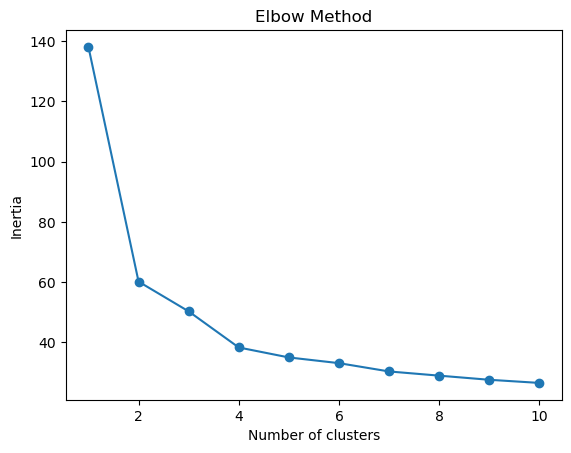

In [30]:

cluster_df = unlabeled_std.drop(columns=["filename", "y", "sr"])

inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(cluster_df)
    inertia.append(kmeans.inertia_)


plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



### Hoe hebben we het aantal clusters bepaald?

Om het aantal clusters in de unlabeled_df te bepalen, hebben we gebruik gemaakt van de **Elbow-methode**. dit is een techniek die veel gebruikt word in clustering om een keuze te maken over het aantal groepen (clusters) dat de data het beste beschrijft. 

in de grafiek hierboven zie je hoe de **inertia** (de som van de kwadraten van de afstanden tot de dichtstbijzijnde clustercentra) afneemt hoelanger het aantal clusters blijft toenemen. Dit is logisch, want met meer clusters kunnen de data beter gegroepeerd worden. na een bepaald punt voegen extra clusters weinig waarde toe, terwijl de complexiteit van het model toeneemt. Dit punt wordt het knikpunt genoemd.

#### Waarom 3 clusters?
- in de grafiek is te zien dat de afname in inertia sterk vertraagt na *3 clusters*. Tot dat punt daalt de inertia aanzienlijk, wat betekent dat het toevoegen van extra clusters echt helpt om de data beter te groeperen.
- na 3 clusters worden de verbeteringen veel kleiner. het toevoegen van meer clusters maakt het model ingewikkelder, maar voegt weinig extra waarde toe.

#### Conclusie:
Op basis van de **Elbow-methode** hebben we geconcludeerd dat *3 clusters* het meest geschikt zijn om de structuur in deze dataset te beschrijven. dit geeft een balans tussen eenvoud en nauwkeurigheid.


## 2.2 Clustering algoritmes

### Inleiding

Clusteranalyse, ook wel clustering genoemd, is een unsupervised learning methode die datapunten groepeert op basis van gemeenschappelijke eigenschappen. Cluster algoritmes volgen allemaal een vergelijkbare werkwijze:        

1. De overeenkomsten tussen datapunten word berekent(GeeksforGeeks, 2024).       
2. De datapunten worden op basis van deze overeenkomsten in groepen (clusters) verdeeld (GeeksforGeeks, 2024).        

In deze documentatie kijken we naar een specifiek clusteralgoritme:     
**K-means**     
**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) (GeeksforGeeks, 2024).     
**Hierarchical clustering** 


### 2.2.1 KMeans clustering

### Wat is K-means?

K-means is een cluster algoritme die data punten groepeert op basis van gemeenschappelijke eigenschappen (GeeksforGeeks, 2025). Het model observeert wat belangrijke eigenschappen zijn die in de data voorkomen, en probeert daar mee te clusteren (GeeksforGeeks, 2025).

### Werking van K-means

K-means begint met het invullen hoeveel clusters er in de dataset zitten, hier kan je achter komen door de elleboogmethode te gebruiken van de inertia. Inertia verwijst naar de som van de kwadratische afstanden tussen elk datapunt en de centroid van de cluster waartoe het behoort (Dicicco, 2022). Het is een maatstaf die verteld hoe goed de data punten passen bij het cluster dat hun toegewezen is (Dicicco, 2022).
De formule van Inertia is als volgt (Dicicco, 2022): 

$
\sum_{i=1}^{n} (x_i - c_k)^2
$

Waarbij:
- X_i, het datapunt is (Dicicco, 2022)  
- C_k, de centroid van de cluster k is (Dicicco, 2022)  
- N, het aantal samples in de dataset is. (Dicicco, 2022)   


Door de inertia te laten zien in een grafiek, en het elleboog punt te vinden kan je het aantal clusters die aanwezig zijn in de dataset zien.

K-means maakt gebruik van de `euclidean distance`, het is mogelijk om andere afstandsmaten te gebruiken maar dan kijk je naar andere modellen zoals k-medians en k-medoids (Chatgpt 4.0, prompt 1: Inertia in ml).
De euclidean distance is de lengte van de lijn die tussen twee datapunten loopt, de formule gaat als volgt (GeeksforGeeks, 2024):   
$
d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$

Waar:   
- d, de afstand is
- x_i, de x coördinaten van de punten zijn (GeeksforGeeks, 2024)    
- y_i, de y coördinaten van de punten zijn (GeeksforGeeks, 2024)    


De stappen van het K-means model zijn:      
**1.**  Als eerst worden er `k` random punten aangemaakt die centroids genoemd worden (GeeksforGeeks, 2024).    
**2.** De afstanden van alle punten tot elke centroid wordt berekend door middel van de euclidean distance. 
**3.** Elk punt wordt toegewezen aan de centroid waar ze het dichtst bij liggen (GeeksforGeeks, 2024).  
**4.** Dit proces herhaalt zich totdat het aantal iteraties behaalt is, of de clusters niet meer veranderen (GeeksforGeeks, 2024).  

Door het proces van stap 1 tm 3 telkens te herhalen probeert het model de clusters te optimaliseren door de afstand tussen de punten en de centroids te minimaliseren (Notebook, unsupervised_1).
De centroids worden ook wel de **mean** genoemd, omdat ze uiteindelijk het in het midden van de clusters zullen liggen, deze punten worden vaak gemaakt door een randomizer (GeeksforGeeks, 2024).

### Parameters van K-means

Om het model te optimaliseren zijn er een aantal parameters die je van te voren kan instellen, hierdoor vergroot je de kans op goede clustering. We zullen kijken naar de eerste 4 parameters van het model:
    
**1. n_clusters:** Dit staat voor het aantal clusters die het model moet maken in de dataset, het aantal bepaal je met de elleboogmethode (KMEANS, n.d.).   
**2. init:** Hier geef je de methode van het aanmaken van de random centroids aan, de default hiervan is 'k-means++' (KMEANS, n.d.).    
**3. n_init:** Dit bepaald hoe vaak het model wordt gedraaid met andere centroids, de default is 'auto' wat betekent dat het afhankelijk is van de 'init' parameter (KMEANS, n.d.). 
**4. max_iter:** Hoe vaak het model moet itereren wanneer het gedraaid wordt (KMEANS, n.d.).    

### Evaluatie metrics

De meest standaard evaluatie metrics voor het K-means algoritme zijn, de elleboogmethode, de silhouette-score, en de calinski-harabasz. Omdat er al uitgelegd is wat de elleboogmethode inhoudt zullen we alleen ingaan op de silhouette-score en de calinski-harabasz index.   

**1. Silhouette Score:**        
- Score loopt van -1 tot 1 (GeeksforGeeks, 2024).     
- Score dichtbij 1 betekent dat het punt goed binnen zijn cluster ligt (GeeksforGeeks, 2024).     
- Score rond 0 duidt op overlappende clusters (GeeksforGeeks, 2024).      
- Score dichtbij -1 wijst op een verkeerde clustering (GeeksforGeeks, 2024).      

De formules gaan als volgt:

$
Silhouette = \frac{b(i) - a(i)}{\max(a(i), b(i))}
(Gültekin, 2023)
$

Waar:   
- A_i, de gemiddelde afstand tot de andere datapunten binnen dezelfde cluster is (Gültekin, 2023).      
- B_i, de gemiddelde afstand tot de andere cluster is (Gültekin, 2023).     
    
 **2. Calinski-Harabsz index:**     
- De verhouding tussen cluster variabiliteit (spreiding van de centroids) tegenover de binnen cluster variabiliteit (spreiding van punten binnen de cluster) (Khandelwal, 2023).    
- De formule gaat als volgt :   
$
CH = \frac{\text{tr}(B_k)}{\text{tr}(W_k)} \cdot \frac{n-K}{K-1} 
$

- Hoe hoger de score van de calinksi-harabasz hoe beter de clusters zijn (Khandelwal, 2023).    

### Voor- en nadelen

Een paar belangrijke voordelen van het K-means model zijn:  
- **Flexibiliteit:** K-means is een erg flexibel model en kan goed omgaan met verandering. Als het aantal clusters aangepast moet worden, kan het algoritme dit snel uitvoeren (J, 2023).   
- **Simpel:** Het algoritme is erg simpel, en de uitkomsten ervan ook. Het is redelijk makkelijk te implementeren, en door middel van visualisaties is het relatief simpel om uit te leggen welke clusters aanwezig zijn en welke eigenschappen ze hebben(J, 2023). 
- **Efficiëntie:** Omdat het model redelijk simpel is, en goed om kan gaan met grootte datasets is de efficiëntie van het model groot(J, 2023). 

Een paar nadelen van het K-means model zijn:    
- **omgang met ouliers:** Het model is niet goed in het omgaan met outliers. Omdat het werkt met centroids zullen outliers er voor zorgen dat de clusters heel groot worden of juist punten gaan missen(J, 2023).   
- **startpunt centroids:** Waar de random centroids starten is van groot belang met dit model, als ze namelijk niet goed liggen kan het model minder goede clusters maken en punten achterwege laten(J, 2023).  
- **Cluster vorm:** De vorm van de clusters kan in een K-means model alleen bolvormig zijn, dit betekent dat als de data deze vorm niet heeft, of als er veel outliers zijn dat het model niet goed kan clusteren(J, 2023). 



### 2.2.2 DBSCAN clustering


### Wat is DBSCAN?  

DBSCAN is een cluster algortime dat datapunten clustert op basis van de density, dit betekent dat dicht bij elkaar liggende punten geclusterd worden. Hier tegenover staat dat het model een lagere dichtheid 'sparisty' ziet als noise.

### Parameters van DBSCAN   

Het algortime maakt gebruik van 2 parameters:   
**1. Eps:** Deze parameter definieert de straal (neighborhood) rondom elk datapunt , punten die binnen de neighborhood liggen worden aanschouwd als buren (GeeksforGeeks, 2024). de optimale waarde van eps wordt bepaald met een **k-distance graph** en de **elleboogmethode** (Shreiber, 2021). De formule van de eps-neighborhood gaat als volgt (Shreiber, 2021):          

$
B_{\epsilon}(x_0) = \{ x \in X \mid d(x, x_0) < \epsilon \}
$

**2. MinPts:** Dit staat voor het minimum aantal punten die binnen de eps-straal moeten liggen, om het als een dichte regio te beschouwen (Shreiber, 2021). De standaard formule om de beste waarde van MinPts te vinden gaat als volgt (GeeksforGeeks, 2024):  

$
MinPts >= D + 1
$

Waar de D staat voor het aantal dimensies in de dataset. De minimum waarde van MinPts is 3 (GeeksforGeeks, 2024).

### Soorten datapunten in DBSCAN    

In dit algoritme word er gesproken over 3 soorten datapunten:

**1. Core points:** Datapunten met minstens MinPts binnen de eps-radius (GeeksforGeeks, 2024).  
**2. Border points:** Datapunten met minder dan MinPts in de eps-radius, maar het ligt wel binnen de neighborhood van een core point (GeeksforGeeks, 2024).     
**3. Noise/outliers:** Datapunten die geen core points zijn, en niet in de neighborhood van een core point liggen (GeeksforGeeks, 2024).    

### Werking van DBSCAN  

Nu we een beter weten waar het model uit bestaat zullen we kijken naar de stappen die het model zet om de datapunten te clusteren.

1. Alle datapunten worden als ongezien gemarkeerd (Shreiber, 2021). 
2. Een willekeurig punt wordt gekozen als startpunt, en gemarkeerd als gezien (Shreiber, 2021). 
3. Het startpunt word gecontroleerd of het een core point is, door het aantal buren binnen de eps-straal te tellen (Shreiber, 2021).    
4. Als het een core point is, wordt een nieuw cluster aangemaakt (GeeksforGeeks, 2024). 
5. Dan wordt er iteratief gezocht naar alle dichtheids-verbonden punten en deze worden toegevoegd aan het cluster (GeeksforGeeks, 2024).    
6. Dit proces herhaalt zich totdat alle punten zijn toegewezen aan een cluster of als noise gemarkeerd zijn (GeeksforGeeks, 2024).  

### Evaluatiemetrics    

DBSCAN maakt gebruikt van verschillende evaluatiemethoden om de kwaliteit van het clusteren te meten, de twee bekendste zijn:

**1. Silhouette Score:**        
    - Score loopt van -1 tot 1 (GeeksforGeeks, 2024).     
    - Score dichtbij 1 betekent dat het punt goed binnen zijn cluster ligt (GeeksforGeeks, 2024).     
    - Score rond 0 duidt op overlappende clusters (GeeksforGeeks, 2024).      
    - Score dichtbij -1 wijst op een verkeerde clustering (GeeksforGeeks, 2024).      

**2. Adjusted Rand Index:**         
    - Waarden lopen van -1 tot 1 (GeeksforGeeks, 2024).        
    - Score van 1 wijst op perfecte overeenkomsten (GeeksforGeeks, 2024).        
    - Score van 0 zegt dat dat het niet beter overeenkomt dan wanneer het toeval is (GeeksforGeeks, 2024).       
    - Score < 0 wijst op slechtere overeenkomsten dan toeval (GeeksforGeeks, 2024).          

De formules gaan als volgt:

$
Silhouette = \frac{b(i) - a(i)}{\max(a(i), b(i))}
(Gültekin, 2023)
$

Waar:   
- A_i, de gemiddelde afstand tot de andere datapunten binnen dezelfde cluster is (Gültekin, 2023).      
- B_i, de gemiddelde afstand tot de andere cluster is (Gültekin, 2023).     

$
ARI = \frac{\max(R) - E}{R - E}
(GeeksforGeeks, 2024)
$

Waar:   
- R, de rand index waarde is (GeeksforGeeks, 2024).     
- E, de verwachte rand index waarde is voor nieuwe clusters (GeeksforGeeks, 2024).  
- Max(R), de hoogste waarde van R is (altijd 1) (GeeksforGeeks, 2024).  

### Voor- en nadelen van DBSCAN 

DBSCAN is een handig model voor complexere data, die niet alleen ronde srtucturen aanneemt (GeeksforGeeks, 2024).   
Daarnaast kan het goed omgaan met noise in de data, en hoef je niet het aantal clusters te weten om het model te maken (GeeksforGeeks, 2024).   
Dit zorgt ervoor dat het handig kan zijn voor grotere datasets, waar je niet veel vanaf weet (Shreiber, 2021).  

Aan de andere kant werkt DBSCAN minder goed met datasets waar er grote verschillen zijn in de dichtheid van de data punten, omdat het de groepen baseerd op de dichtheid van de punten (Shreiber, 2021).    
Daarnaast kan het lasting zijn om de beste parameter waarden te bepalen, en kost het veel computer kracht omdat het elk individueel punt afgaat (Shreiber, 2021).   
    

### 2.2.3 Hiërarchische

## Hiërarchische clustering

Hiërarchische clustering is een methode om gegevens in een boomstructuur van clusters te groeperen. Het algoritme begint door elk datapunt als een apart cluster te behandelen. Vervolgens worden de volgende stappen herhaald (GeeksforGeeks, 2023):

1. Identificeer de twee clusters die het dichtst bij elkaar liggen.
2. Voeg deze twee clusters samen.
3. Herhaal stap 1 en 2 totdat er één cluster overblijft.

Het resultaat is een hiërarchische reeks van geneste clusters. Een dendrogram, een diagram dat de clustering grafisch weergeeft, laat zien hoe clusters worden samengevoegd (bottom-up) of gesplitst (top-down).

### Soorten hiërarchische clustering
Hiërarchische clustering kan op twee manieren werken (GeeksforGeeks, 2024):

- Agglomeratief (bottom-up): Start met elk datapunt als een afzonderlijk cluster en voeg clusters samen op basis van gelijkenis. Dit proces blijft doorgaan totdat er één cluster overblijft.

- Divisief (top-down): Start met één groot cluster dat alle data bevat en splits iteratief totdat elk datapunt in zijn eigen cluster zit. Deze methode is minder vaak toegepast vanwege de hogere computationele kosten.


### Berekening van de afstandsmatrix
Bij het samenvoegen van twee clusters controleren we de afstand tussen twee clusterparen en voegen we het paar met de minste afstand/meeste gelijkenis samen. Maar de vraag is hoe die afstand wordt bepaald. Er zijn verschillende manieren om de Cluster afstand/gelijkenis te definiëren. Enkele daarvan zijn (GeeksforGeeks, 2024):

- Single linkage: Bepaal de minimale afstand tussen twee punten van de cluster.
- Complete linkage: Bepaal de maximale afstand tussen twee punten van de cluster.
- Average linkage: Bepaal de gemiddelde afstand tussen elke twee punten van de clusters.
- Ward's linkage: De gelijkenis van twee clusters is gebaseerd op de toename van de kwadratische fout wanneer twee clusters worden samengevoegd.




### Voordelen en Nadelen

Voordelen:

- Flexibiliteit: Verschillende definities van afstand en linkage maken het algoritme breed toepasbaar (Pai, 2022).
- Geen vooraf ingesteld aantal clusters: Het algoritme bepaalt automatisch het aantal clusters op basis van de gegevens en de koppelingsmethode (Sharma, 2024).
- Geschikt voor kleine datasets: Het biedt een duidelijke visuele weergave met dendrogrammen.
- Interpretatie: Het dendrogram laat de relaties tussen clusters zien, wat de interpretatie van de resultaten vereenvoudigt (Pai, 2022).
- Robuustheid tegen ruis: Doordat alle data worden gebruikt, kan het algoritme goed omgaan met ruis en outliers (Sharma, 2024).


Nadelen:
- Rekenkracht: De computationele complexiteit is hoog, namelijk  voor grote datasets (Sharma, 2024).
- Gevoeligheid voor ruis: Outliers kunnen de structuur van de clusters verstoren.
- Geen correctie achteraf: Eenmaal gemaakte beslissingen kunnen niet worden teruggedraaid.
- Schaling naar grote datasets: Hiërarchische clustering vereist veel geheugen om de volledige afstandsmatrix op te slaan (Sharma, 2024).




### Waarom dit algoritme onderzoeken?
Hiërarchische clustering biedt een waardevolle aanvulling op k-means en DBSCAN, omdat het:

- Geen vaste clusterindeling vereist.
- Een visuele en intuïtieve manier biedt om patronen te ontdekken.
- Geschikt is voor datasets waar ruis en kleine afwijkingen niet te dominant zijn.

### Voorbeeld hoe Agglomeratief Hiërarchische clustering werkt

Stel dat een docent haar studenten in verschillende groepen wil verdelen. Ze heeft de punten die elke student in een opdracht heeft behaald en op basis van deze punten wil ze ze in groepen verdelen. Er is hier geen vast doel voor hoeveel groepen er moeten zijn. We zullen hier proberen hiërarchische clustering toe te passen om de studenten in verschillende groepen te verdelen. (Sharma, 2024)

| student_id   |  punten |
|--------------|---------|
| 1            | 10      |
| 2            | 7       |
| 3            | 28      |
| 4            | 20      |
| 5            | 35      |


Eerst maken we een nabijheidsmatrix die ons de afstand tussen elk van deze punten vertelt. Omdat we de afstand van elk punt tot elk van de andere punten berekenen, krijgen we een vierkante matrix van vorm n X n (waarbij n het aantal observaties is).

| ID | 1  | 2  | 3  | 4  | 5  |
|----|----|----|----|----|----|
| 1  | 0  | 3  | 18 | 10 | 25 |
| 2  | 3  | 0  | 21 | 13 | 28 |
| 3  | 18 | 21 | 0  | 8  | 7  |
| 4  | 10 | 13 | 8  | 0  | 15 |
| 5  | 25 | 28 | 7  | 15 | 0  |


#### stap 1
Eerst wijzen we alle punten toe aan een individuele cluster
Verschillende kleuren vertegenwoordigen hier verschillende clusters. U kunt zien dat we 5 verschillende clusters hebben voor de 5 punten in onze data.

------------------------------------------------------------


<div style="display: flex; align-items: center; justify-content: space-around; width: 300px;">
  <div style="background-color: blue; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center;"></div>
  <div style="background-color: magenta; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center;"></div>
  <div style="background-color: lime; color: black; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center;"></div>
  <div style="background-color: orange; color: black; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center;"></div>
  <div style="background-color: darkgreen; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center;"></div>
</div>


--------------------------------------------------------------

#### Stap 2
Vervolgens kijken we naar de kleinste afstand in de nabijheidsmatrix en voegen de punten met de kleinste afstand samen. Vervolgens updaten we de nabijheidsmatrix:

| ID | 1  | 2  | 3  | 4  | 5  |
|----|----|----|----|----|----|
| 1  | 0  | **(3)**  | 18 | 10 | 25 |
| 2  | **(3)**  | 0  | 21 | 13 | 28 |
| 3  | 18 | 21 | 0  | 8  | 7  |
| 4  | 10 | 13 | 8  | 0  | 15 |
| 5  | 25 | 28 | 7  | 15 | 0  |


Hier is de kleinste afstand 3 en daarom zullen we punt 1 en 2 samenvoegen:

----------------------------------------------------------------


<div style="display: flex; align-items: center; justify-content: space-around; position: relative; width: 400px; height: 150px;">
  <!-- Circles -->
  <div style="background-color: blue; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; position: absolute; top: 20px; left: 20px;"></div>
  <div style="background-color: magenta; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; position: absolute; top: 20px; left: 100px;"></div>
  <div style="background-color: lime; color: black; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; position: absolute; top: 20px; left: 180px;"></div>
  <div style="background-color: orange; color: black; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; position: absolute; top: 20px; left: 260px;"></div>
  <div style="background-color: darkgreen; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; position: absolute; top: 20px; left: 340px;"></div>

  <!-- Connecting lines -->
  <div style="position: absolute; width: 2px; height: 40px; background-color: gray; top: 60px; left: 40px;"></div>
  <div style="position: absolute; width: 2px; height: 40px; background-color: gray; top: 60px; left: 120px;"></div>
  <div style="position: absolute; width: 80px; height: 2px; background-color: gray; top: 100px; left: 40px;"></div>
  <div style="position: absolute; width: 2px; height: 20px; background-color: gray; top: 100px; left: 80px;"></div>

  <!-- Bottom circles -->
  <div style="background-color: blue; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; position: absolute; top: 120px; left: 20px;"></div>
  <div style="background-color: magenta; color: white; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; position: absolute; top: 120px; left: 100px;"></div>

  <!-- Text -->
  <div style="position: absolute; top: 140px; left: 65px; font-size: 12px;">(1,2)</div>
</div>

--------------------------------------------------------------------

Laten we eens kijken naar de bijgewerkte clusters en de nabijheidsmatrix dienovereenkomstig bijwerken:

| student_id   |  punten |
|--------------|---------|
| (1,2)        | 10      |
| 3            | 28      |
| 4            | 20      |
| 5            | 35      |


Hier hebben we het maximum van de twee markeringen (7, 10) genomen om de markeringen voor deze cluster te vervangen. In plaats van het maximum kunnen we ook de minimumwaarde of de gemiddelde waarden nemen. Nu zullen we opnieuw de nabijheidsmatrix voor deze clusters berekenen:

| ID   | (1,2) | 3  | 4  | 5  |
|------|-------|----|----|----|
| (1,2)| 0     | 18 | 10 | 25 |
| 3    | 18    | 0  | 8  | 7  |
| 4    | 10    | 8  | 0  | 15 |
| 5    | 25    | 7  | 15 | 0  |

#### STAP 3

We herhalen stap 2 totdat er nog maar één cluster over is.
Dus, we zullen eerst kijken naar de minimale afstand in de nabijheidsmatrix en dan het dichtstbijzijnde paar clusters samenvoegen.

### 2.2.4 Uiteindelijke keuze

## Waarom hebben we gekozen voor K-means?
Voor de clustering in dit project hebben we gekozen voor het K-means algoritme. Dit besluit is genomen op basis van de kenmerken van onze dataset en de sterke punten van K-means als clustering-algoritme. Hieronder leggen we uit waarom K-means de meest geschikte keuze is:

1. Schaalbaarheid en efficiëntie

K-means is een van de meest efficiënte clustering-algoritmes, vooral geschikt voor grotere datasets. Het algoritme verdeelt de data iteratief over 
𝑘
k clusters en convergeert snel naar een oplossing. Gezien de omvang en complexiteit van onze dataset, was het belangrijk een methode te kiezen die schaalbaar is en binnen een redelijke tijd betrouwbare resultaten levert.

2. Goed passend bij gestructureerde data

Onze dataset bevat voornamelijk numerieke en continue variabelen, zoals kenmerken uit audiogegevens (bijvoorbeeld bandbreedte, spectral centroid, MFCC’s). Deze kenmerken zijn ideaal voor een algoritme als K-means, dat gebruikmaakt van afstandsmetingen, zoals de Euclidische afstand, om clusters te bepalen. De data heeft bovendien weinig tot geen onregelmatigheden, zoals extreme ruis of afwijkingen, waardoor de eenvoud van K-means goed tot zijn recht komt.

3. Clusterstructuur en bolvormige clusters

K-means werkt optimaal wanneer de clusters bolvormig zijn en vergelijkbare dichtheden hebben. Onze verkennende data-analyse toonde aan dat de datapunten relatief gelijkmatig verdeeld zijn en dat er geen complexe patronen, zoals sterk overlappende clusters of variërende dichtheden, aanwezig zijn. Dit maakt K-means zeer geschikt, aangezien het algoritme bolvormige clusters kan identificeren en de data overzichtelijk indeelt.

4. Optimaal aantal clusters bepalen met de Elbow-methode

Een belangrijke stap bij het gebruik van K-means is het bepalen van het optimale aantal clusters (
𝑘
k). Met behulp van de Elbow-methode konden we dit nauwkeurig vaststellen. Door te kijken naar de afname van de ‘inertia’ (de som van de kwadratische afstanden binnen clusters) konden we een duidelijk knikpunt identificeren. Dit bevestigde dat K-means een goede match is voor onze data, omdat we een logisch aantal clusters konden definiëren zonder willekeur.

5. Eenvoudige interpretatie en visualisatie

Een belangrijk voordeel van K-means is de eenvoud van de resultaten en de interpretatie ervan. Nadat de data in clusters is verdeeld, kunnen we deze gemakkelijk visualiseren in bijvoorbeeld 2D- of 3D-ruimte. Daarnaast maakt de intuïtieve werking van K-means het gemakkelijker om de resultaten te presenteren en te valideren, wat belangrijk is voor de verdere analyse en besluitvorming in ons project.

6. Vergelijking met andere algoritmes

We hebben K-means vergeleken met andere clustering-algoritmes, zoals DBSCAN en hiërarchische clustering, en vonden K-means beter aansluiten bij onze dataset en doelen:

- DBSCAN: Hoewel DBSCAN geschikt is voor datasets met clusters van ongelijke vorm of dichtheid, is het minder geschikt voor onze dataset omdat er geen sprake is van grote dichtheidsvariaties. Bovendien is DBSCAN gevoeliger voor het instellen van parameters zoals de straal (𝑒𝑝𝑠) en het minimum aantal punten per cluster, wat kan leiden tot inconsistente resultaten.
- Hiërarchische clustering: Dit algoritme biedt voordelen bij het analyseren van kleinere datasets met een duidelijke hiërarchische structuur. Echter, bij grotere datasets zoals de onze, wordt hiërarchische clustering rekenkundig intensief en moeilijk schaalbaar, wat het minder praktisch maakt.

7. Balans tussen eenvoud en prestaties

K-means biedt een ideale balans tussen eenvoud, prestaties en nauwkeurigheid. Het algoritme is relatief snel en betrouwbaar, terwijl het voldoende flexibiliteit biedt om waardevolle inzichten te verkrijgen zonder dat er complexe parameterafstemming of voorverwerking nodig is. Dit maakt K-means een logische keuze, zeker in de context van dit project, waar de eerste focus ligt op het vinden van duidelijke clusters in de data.

**Conclusie**
Op basis van bovenstaande overwegingen hebben we gekozen voor K-means als clustering-algoritme. Het is efficiënt, goed schaalbaar, intuïtief interpreteerbaar en zeer geschikt voor onze gestructureerde dataset. Bovendien stelde de Elbow-methode ons in staat om het optimale aantal clusters te bepalen, wat het succes van dit algoritme verder onderstreept. K-means biedt een robuuste basis voor het ontdekken van patronen in onze data en draagt bij aan de overall doelstellingen van dit project.


## 2.3 Model maken

In [31]:
cluster_df

,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_11,mfcc_12,bpm,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio
0,0.448643,0.075108,0.422214,0.519917,0.344439,0.244003,0.173477,0.297502,0.429764,0.504307,...,0.455023,0.422764,0.592105,0.463376,0.430506,0.485932,0.480232,0.673624,0.414247,0.490294
1,0.531128,0.220793,0.853677,0.858454,0.242589,0.207237,0.271963,0.523071,0.617052,0.509902,...,0.622673,0.457112,0.225000,0.660227,0.391707,0.804057,0.843487,0.671897,0.671283,0.528182
2,0.370063,0.017327,0.058733,0.074858,0.049558,0.027838,0.013718,0.030091,0.041755,0.046852,...,0.121747,0.109192,0.138889,0.372433,0.761167,0.504071,0.090376,0.601435,0.075331,0.451294
3,0.449306,0.073064,0.306792,0.357836,0.184544,0.114379,0.077865,0.178919,0.307734,0.385211,...,0.393043,0.394579,0.592105,0.502532,0.354462,0.518611,0.361654,0.651839,0.300967,0.464694
4,0.000000,0.000000,0.017325,0.030025,0.041554,0.043486,0.043767,0.054209,0.051953,0.046964,...,0.102558,0.092107,0.273438,0.022481,0.415766,0.112755,0.042101,0.570266,0.042905,0.793830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263604,0.050984,0.094486,0.137552,0.152406,0.126336,0.094128,0.081548,0.067180,0.053501,...,0.087358,0.079292,0.273438,0.243903,0.278185,0.329446,0.126829,0.711859,0.106338,0.191083
101,0.917757,0.746175,0.892231,0.517523,0.736635,0.782761,0.576430,0.601352,0.722166,0.591207,...,0.585949,0.626417,0.515625,0.889547,0.121853,0.714577,0.866487,0.486023,0.805117,0.325293
102,0.943273,0.751152,0.682148,0.399214,0.598739,0.712525,0.560051,0.474764,0.416281,0.405064,...,0.514916,0.472692,0.225000,0.971338,0.092408,0.745752,0.714898,0.921389,0.744829,0.516833
103,0.193159,0.001253,0.019320,0.030793,0.038060,0.039239,0.040728,0.056441,0.061048,0.062791,...,0.139371,0.133555,0.383523,0.080740,0.761791,0.069576,0.038634,0.681887,0.037543,0.367818


In [32]:
# maken van K_means
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(cluster_df)
cluster_df["cluster"] = kmeans.labels_
unlabeled_std["cluster"] = kmeans.labels_
cluster_df["filename"] = unlabeled_df["filename"]

c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [33]:
cluster_to_genre_original = {
    0: "pop",
    1: "classical",
    2: "metal"
}
cluster_df["Predicted_Genre"] = cluster_df["cluster"].map(cluster_to_genre_original)

# hier berekenen we de silhouette_score
numerical_columns = cluster_df.select_dtypes(include=[np.number]).drop(columns=["cluster"])
silhouette_avg = silhouette_score(numerical_columns, cluster_df["cluster"])
print(f"Silhouette Score zonder NMF: {silhouette_avg:.4f}")

# hier maken we een bestand aan voor de score in kaggle
submission_df = cluster_df[["filename", "Predicted_Genre"]].rename(columns={"Predicted_Genre": "genre"})
submission_df = submission_df.sort_values(by="filename").reset_index(drop=True)
submission_df.to_csv("submission_original.csv", index=False)

# hier controleren we het bestand of het aan de eisen van kaggle voldoet, kolomnamen filename en genre en moet 105 rijen hebben.
print("Submissiebestand opgeslagen als 'submission_original.csv'")
display(submission_df.head())
print(submission_df.shape)

Silhouette Score zonder NMF: 0.3395
Submissiebestand opgeslagen als 'submission_original.csv'


,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,classical
3,m00043.wav,metal
4,m00044.wav,classical


(105, 2)


### feature importance van het clusteringalgoritme op de dataset

we bepalen de belangrijkste feautures van het clusteralgoritme op de dataset. Dit doen we door systematisch één feature te verwijderen en de Silhouette Score opnieuw te berekenen. Dit laat zien hoe belangrijk een feature is voor de clustering.

#### hoe werkt de code
1. Feature verwijderen: Bij elke iteratie verwijderen we één feature en passen we de clustering opnieuw toe.
2. Silhouette Score berekenen: We meten hoe goed de clustering is zonder de specifieke feature.
3. Impact meten: Een lagere Silhouette Score betekent dat de verwijderde feature belangrijk is voor de clustering.
4. Resultaten sorteren: Features worden gesorteerd op hun impact, van meest naar minst belangrijk.

In [34]:
numerical_columns = cluster_df.select_dtypes(include=[np.number]).columns
cluster_df_numerical = cluster_df[numerical_columns]

feature_importance = []

for feature in cluster_df_numerical.columns.drop("cluster"):
    reduced_df = cluster_df_numerical.drop(columns=[feature])
    
    kmeans = KMeans(n_clusters=3, random_state=0)
    cluster_labels = kmeans.fit_predict(reduced_df)
    
    score = silhouette_score(reduced_df, cluster_labels)
    
    feature_importance.append((feature, score))

feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

print("Belangrijkste features op basis van Silhouette Score:")
for feature, score in feature_importance_sorted:
    print(f"Feature: {feature}, Silhouette Score: {score:.4f}")

feature_importance_df = pd.DataFrame(feature_importance_sorted, columns=["Feature", "Silhouette Score"])
display(feature_importance_df)

c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have

Belangrijkste features op basis van Silhouette Score:
Feature: bpm, Silhouette Score: 0.5696
Feature: band_energy_ratio, Silhouette Score: 0.5684
Feature: spectral_flux, Silhouette Score: 0.5646
Feature: zero_crossing_rate, Silhouette Score: 0.5618
Feature: spectral_contrast, Silhouette Score: 0.5586
Feature: mfcc_2, Silhouette Score: 0.5562
Feature: mfcc_12, Silhouette Score: 0.5557
Feature: mfcc_3, Silhouette Score: 0.5555
Feature: mfcc_4, Silhouette Score: 0.5549
Feature: mfcc_11, Silhouette Score: 0.5546
Feature: spectral_centroid, Silhouette Score: 0.5544
Feature: mfcc_5, Silhouette Score: 0.5543
Feature: flatness, Silhouette Score: 0.5539
Feature: mfcc_6, Silhouette Score: 0.5539
Feature: mfcc_10, Silhouette Score: 0.5533
Feature: bandwidth, Silhouette Score: 0.5529
Feature: mfcc_7, Silhouette Score: 0.5529
Feature: mfcc_9, Silhouette Score: 0.5527
Feature: mfcc_8, Silhouette Score: 0.5522
Feature: mfcc_0, Silhouette Score: 0.5521
Feature: mfcc_1, Silhouette Score: 0.5516
Feature

c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Feature,Silhouette Score
0,bpm,0.569587
1,band_energy_ratio,0.568394
2,spectral_flux,0.564559
3,zero_crossing_rate,0.561848
4,spectral_contrast,0.558581
5,mfcc_2,0.556176
6,mfcc_12,0.555678
7,mfcc_3,0.555469
8,mfcc_4,0.554897
9,mfcc_11,0.554593


In [35]:
cluster_df

,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio,cluster,filename,Predicted_Genre
0,0.448643,0.075108,0.422214,0.519917,0.344439,0.244003,0.173477,0.297502,0.429764,0.504307,...,0.463376,0.430506,0.485932,0.480232,0.673624,0.414247,0.490294,2,m00003.wav,metal
1,0.531128,0.220793,0.853677,0.858454,0.242589,0.207237,0.271963,0.523071,0.617052,0.509902,...,0.660227,0.391707,0.804057,0.843487,0.671897,0.671283,0.528182,2,m00012.wav,metal
2,0.370063,0.017327,0.058733,0.074858,0.049558,0.027838,0.013718,0.030091,0.041755,0.046852,...,0.372433,0.761167,0.504071,0.090376,0.601435,0.075331,0.451294,1,m00013.wav,classical
3,0.449306,0.073064,0.306792,0.357836,0.184544,0.114379,0.077865,0.178919,0.307734,0.385211,...,0.502532,0.354462,0.518611,0.361654,0.651839,0.300967,0.464694,2,m00043.wav,metal
4,0.000000,0.000000,0.017325,0.030025,0.041554,0.043486,0.043767,0.054209,0.051953,0.046964,...,0.022481,0.415766,0.112755,0.042101,0.570266,0.042905,0.793830,1,m00044.wav,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263604,0.050984,0.094486,0.137552,0.152406,0.126336,0.094128,0.081548,0.067180,0.053501,...,0.243903,0.278185,0.329446,0.126829,0.711859,0.106338,0.191083,1,m00971.wav,classical
101,0.917757,0.746175,0.892231,0.517523,0.736635,0.782761,0.576430,0.601352,0.722166,0.591207,...,0.889547,0.121853,0.714577,0.866487,0.486023,0.805117,0.325293,0,m00973.wav,pop
102,0.943273,0.751152,0.682148,0.399214,0.598739,0.712525,0.560051,0.474764,0.416281,0.405064,...,0.971338,0.092408,0.745752,0.714898,0.921389,0.744829,0.516833,0,m00988.wav,pop
103,0.193159,0.001253,0.019320,0.030793,0.038060,0.039239,0.040728,0.056441,0.061048,0.062791,...,0.080740,0.761791,0.069576,0.038634,0.681887,0.037543,0.367818,1,m00991.wav,classical


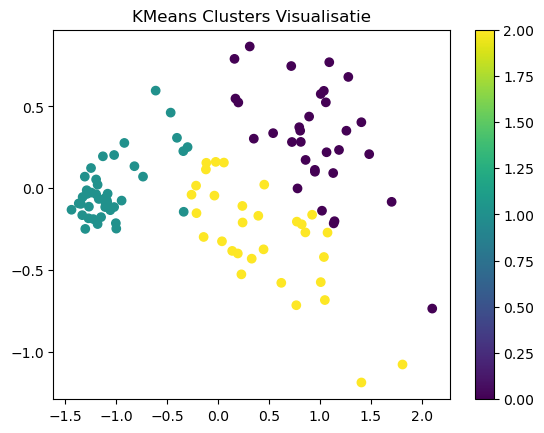

In [36]:
# PCA toepassen op de data
numerical_columns = cluster_df.select_dtypes(include=[np.number]).drop(columns=["cluster"])

pca = PCA(n_components=2)
pca_components = pca.fit_transform(numerical_columns)

# Visualisatie van de clusters
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=cluster_df['cluster'], cmap='viridis')
plt.colorbar()
plt.title('KMeans Clusters Visualisatie')
plt.show()

In [37]:
# toevoegen van de clusters in cluster_df
cluster_df

,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,spectral_centroid,spectral_contrast,zero_crossing_rate,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio,cluster,filename,Predicted_Genre
0,0.448643,0.075108,0.422214,0.519917,0.344439,0.244003,0.173477,0.297502,0.429764,0.504307,...,0.463376,0.430506,0.485932,0.480232,0.673624,0.414247,0.490294,2,m00003.wav,metal
1,0.531128,0.220793,0.853677,0.858454,0.242589,0.207237,0.271963,0.523071,0.617052,0.509902,...,0.660227,0.391707,0.804057,0.843487,0.671897,0.671283,0.528182,2,m00012.wav,metal
2,0.370063,0.017327,0.058733,0.074858,0.049558,0.027838,0.013718,0.030091,0.041755,0.046852,...,0.372433,0.761167,0.504071,0.090376,0.601435,0.075331,0.451294,1,m00013.wav,classical
3,0.449306,0.073064,0.306792,0.357836,0.184544,0.114379,0.077865,0.178919,0.307734,0.385211,...,0.502532,0.354462,0.518611,0.361654,0.651839,0.300967,0.464694,2,m00043.wav,metal
4,0.000000,0.000000,0.017325,0.030025,0.041554,0.043486,0.043767,0.054209,0.051953,0.046964,...,0.022481,0.415766,0.112755,0.042101,0.570266,0.042905,0.793830,1,m00044.wav,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263604,0.050984,0.094486,0.137552,0.152406,0.126336,0.094128,0.081548,0.067180,0.053501,...,0.243903,0.278185,0.329446,0.126829,0.711859,0.106338,0.191083,1,m00971.wav,classical
101,0.917757,0.746175,0.892231,0.517523,0.736635,0.782761,0.576430,0.601352,0.722166,0.591207,...,0.889547,0.121853,0.714577,0.866487,0.486023,0.805117,0.325293,0,m00973.wav,pop
102,0.943273,0.751152,0.682148,0.399214,0.598739,0.712525,0.560051,0.474764,0.416281,0.405064,...,0.971338,0.092408,0.745752,0.714898,0.921389,0.744829,0.516833,0,m00988.wav,pop
103,0.193159,0.001253,0.019320,0.030793,0.038060,0.039239,0.040728,0.056441,0.061048,0.062791,...,0.080740,0.761791,0.069576,0.038634,0.681887,0.037543,0.367818,1,m00991.wav,classical


### 2.3.1 Uitleg van K-means
 ### Werking van K-means

K-means begint met het invullen hoeveel clusters er in de dataset zitten, hier kan je achter komen door de elleboogmethode te gebruiken van de inertia. Inertia verwijst naar de som van de kwadratische afstanden tussen elk datapunt en de centroid van de cluster waartoe het behoort (Dicicco, 2022). Het is een maatstaf die verteld hoe goed de data punten passen bij het cluster dat hun toegewezen is (Dicicco, 2022).
De formule van Inertia is als volgt (Dicicco, 2022): 

$
\sum_{i=1}^{n} (x_i - c_k)^2
$

Waarbij:
- X_i, het datapunt is (Dicicco, 2022)  
- C_k, de centroid van de cluster k is (Dicicco, 2022)  
- N, het aantal samples in de dataset is. (Dicicco, 2022)   


Door de inertia te laten zien in een grafiek, en het elleboog punt te vinden kan je het aantal clusters die aanwezig zijn in de dataset zien.

K-means maakt gebruik van de `euclidean distance`, het is mogelijk om andere afstandsmaten te gebruiken maar dan kijk je naar andere modellen zoals k-medians en k-medoids (Chatgpt 4.0, prompt 1: Inertia in ml).
De euclidean distance is de lengte van de lijn die tussen twee datapunten loopt, de formule gaat als volgt (GeeksforGeeks, 2024):   
$
d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$

Waar:   
- d, de afstand is
- x_i, de x coördinaten van de punten zijn (GeeksforGeeks, 2024)    
- y_i, de y coördinaten van de punten zijn (GeeksforGeeks, 2024)    

De stappen van het K-means model zijn:      
**1.**  Als eerst worden er `k` random punten aangemaakt die centroids genoemd worden (GeeksforGeeks, 2024).    
**2.** De afstanden van alle punten tot elke centroid wordt berekend door middel van de euclidean distance. 
**3.** Elk punt wordt toegewezen aan de centroid waar ze het dichtst bij liggen (GeeksforGeeks, 2024).  
**4.** Dit proces herhaalt zich totdat het aantal iteraties behaalt is, of de clusters niet meer veranderen (GeeksforGeeks, 2024).  

Door het proces van stap 1 tm 3 telkens te herhalen probeert het model de clusters te optimaliseren door de afstand tussen de punten en de centroids te minimaliseren (Notebook, unsupervised_1).
De centroids worden ook wel de **mean** genoemd, omdat ze uiteindelijk het in het midden van de clusters zullen liggen, deze punten worden vaak gemaakt door een randomizer (GeeksforGeeks, 2024).

### K-means Algoritme: Rekenvoorbeeld 
(Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)

We hebben de volgende kleine dataset van 2D-punten:
- X = [(1, 2), (2, 3), (3, 3), (8, 8), (9, 9), (10, 10)]

We willen deze punten clusteren in $ k = 2 $ clusters.

### Stap 1: Initialisatie
(Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)
We kiezen willekeurig 2 punten als de initiële clustercentra:

c1 = (1, 2), c2 = (10, 10)


### Stap 2: Toewijzing van punten aan clusters
(Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)
Bereken voor elk datapunt de afstand tot de twee clustercentra en wijs elk punt toe aan het dichtstbijzijnde centrum.

- Voor punt (1, 2):
  - Afstand tot $ c1 = (1, 2) is 0 . $
  - Afstand tot $ c2 = (10, 10) $ is $ \sqrt{(1-10)^2 + (2-10)^2} = \sqrt{81 + 64} = \sqrt{145} \approx 12.04 $.
  - Het dichtstbijzijnde centrum is $ c1 $, dus (1, 2) wordt toegewezen aan cluster 1.

- Voor punt (2, 3):
  - Afstand tot $ c1 = (1, 2) $ is $ \sqrt{(2-1)^2 + (3-2)^2} = \sqrt{1 + 1} = \sqrt{2} \approx 1.41 $.
  - Afstand tot $ c2 = (10, 10) $ is $ \sqrt{(2-10)^2 + (3-10)^2} = \sqrt{64 + 49} = \sqrt{113} \approx 10.63 $.
  - Het dichtstbijzijnde centrum is $ c1 $, dus (2, 3) wordt toegewezen aan cluster 1.

- Voor punt (3, 3):
  - Afstand tot $ c1 = (1, 2) $ is $ \sqrt{(3-1)^2 + (3-2)^2} = \sqrt{4 + 1} = \sqrt{5} \approx 2.24 $.
  - Afstand tot $ c2 = (10, 10) $ is $ \sqrt{(3-10)^2 + (3-10)^2} = \sqrt{49 + 49} = \sqrt{98} \approx 9.90 $.
  - Het dichtstbijzijnde centrum is $ c1 $, dus (3, 3) wordt toegewezen aan cluster 1.

- Voor punt (8, 8):
  - Afstand tot $ c1 = (1, 2) $ is $ \sqrt{(8-1)^2 + (8-2)^2} = \sqrt{49 + 36} = \sqrt{85} \approx 9.22 $.
  - Afstand tot $ c2 = (10, 10) $ is $ \sqrt{(8-10)^2 + (8-10)^2} = \sqrt{4 + 4} = \sqrt{8} \approx 2.83 $.
  - Het dichtstbijzijnde centrum is $ c2 $, dus (8, 8) wordt toegewezen aan cluster 2.

- Voor punt (9, 9):
  - Afstand tot $ c1 = (1, 2) $ is $ \sqrt{(9-1)^2 + (9-2)^2} = \sqrt{64 + 49} = \sqrt{113} \approx 10.63 $.
  - Afstand tot $ c2 = (10, 10) $ is $ \sqrt{(9-10)^2 + (9-10)^2} = \sqrt{1 + 1} = \sqrt{2} \approx 1.41 $.
  - Het dichtstbijzijnde centrum is $ c2 $, dus (9, 9) wordt toegewezen aan cluster 2.

- Voor punt (10, 10):
  - Afstand tot $ c1 = (1, 2) $ is $ \sqrt{(10-1)^2 + (10-2)^2} = \sqrt{81 + 64} = \sqrt{145} \approx 12.04 $.
  - Afstand tot $ c2 = (10, 10) $is 0.
  - Het dichtstbijzijnde centrum is $ c2 $ dus (10, 10) wordt toegewezen aan cluster 2.

Na deze stap zijn de punten als volgt toegewezen:
- **Cluster 1:** (1, 2), (2, 3), (3, 3)
- **Cluster 2:** (8, 8), (9, 9), (10, 10)

### Stap 3: Herberekening van de clustercentra
(Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)
Bereken de nieuwe clustercentra als het gemiddelde van de toegewezen punten:

- **Nieuw centrum voor cluster 1:**
(Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)
  $
  c1 = \left( \frac{1+2+3}{3}, \frac{2+3+3}{3} \right) = (2, 2.67)
  $

- **Nieuw centrum voor cluster 2:**
(Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)
  $
  c2 = \left( \frac{8+9+10}{3}, \frac{8+9+10}{3} \right) = (9, 9)
  $

### Stap 4: Iteratie
(Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)
Herhaal de toewijzing en herberekening totdat de clustercentra niet meer veranderen.

Na een paar iteraties zouden de clustercentra stabiliseren, en de clusters zouden als volgt kunnen uitkomen:
- **Cluster 1:** (1, 2), (2, 3), (3, 3)
- **Cluster 2:** (8, 8), (9, 9), (10, 10)


c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


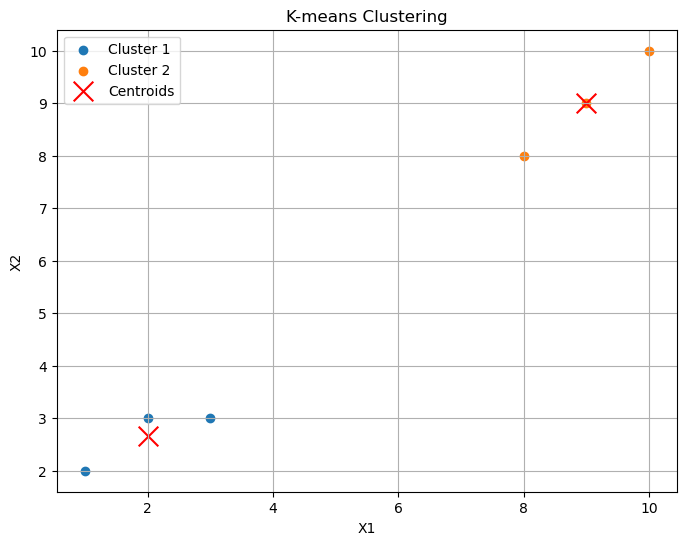

In [38]:
# Dataset
X = np.array([[1, 2], [2, 3], [3, 3], [8, 8], [9, 9], [10, 10]])

# K-means model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Resultaten
labels = kmeans.labels_ 
centroids = kmeans.cluster_centers_ 

# Visualisatie
plt.figure(figsize=(8, 6))

# Plot datapunten, met kleur per cluster
for cluster in range(2):
    cluster_points = X[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}')

# Plot clustercentra
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=200, label='Centroids')

# Labels en titels
plt.title('K-means Clustering')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid()
plt.show()


## 2.4 Clusters vergelijken

In [39]:
import seaborn as sns

# Gemiddelde kenmerken 
cluster_means= unlabeled_df.groupby("cluster").mean()


genre_means =labeled_df.groupby("genre").mean()

#visualisatie
selected_features = [
    "bandwidth", "flatness", "spectral_centroid", "spectral_contrast", 
    "bpm", "zero_crossing_rate"
]



C:\Users\Miche\AppData\Local\Temp\ipykernel_14548\2532892054.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means= unlabeled_df.groupby("cluster").mean()
C:\Users\Miche\AppData\Local\Temp\ipykernel_14548\2532892054.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_means =labeled_df.groupby("genre").mean()


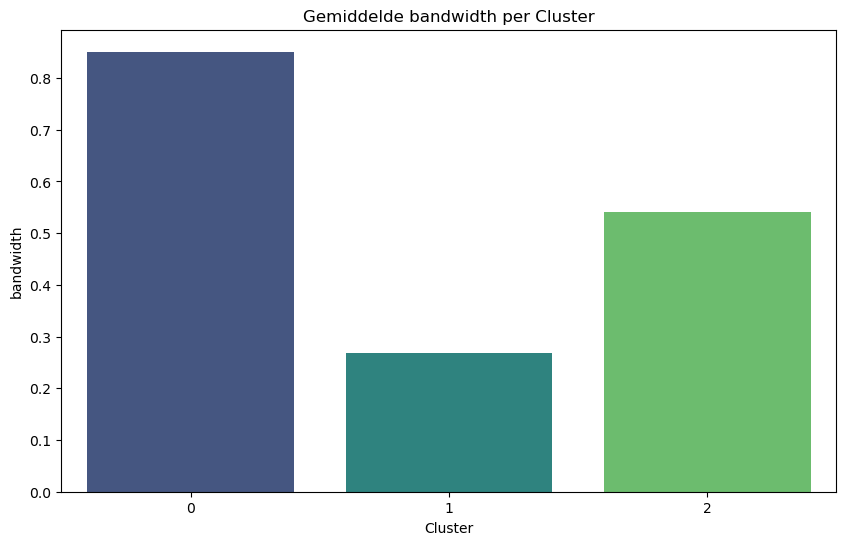

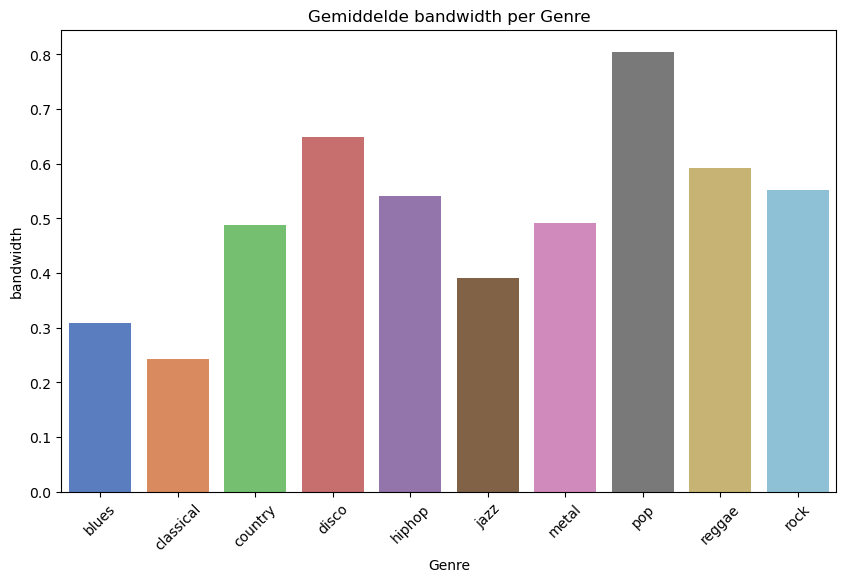

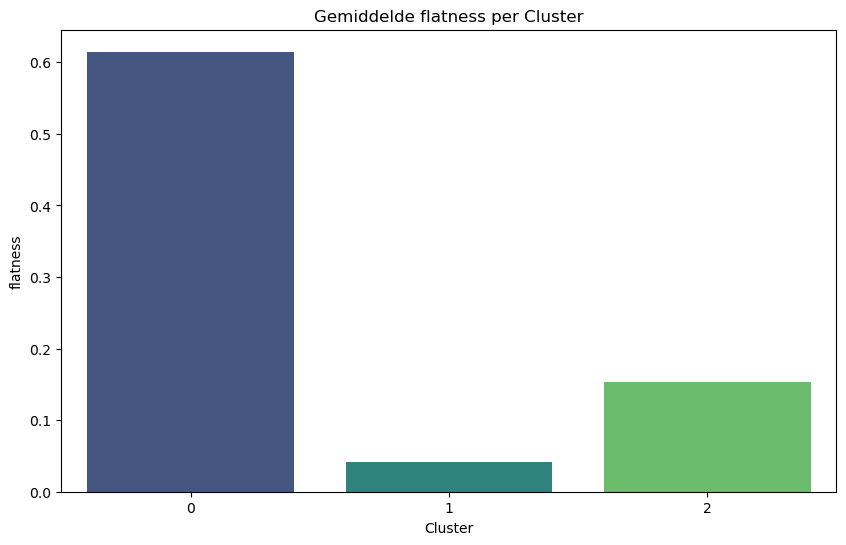

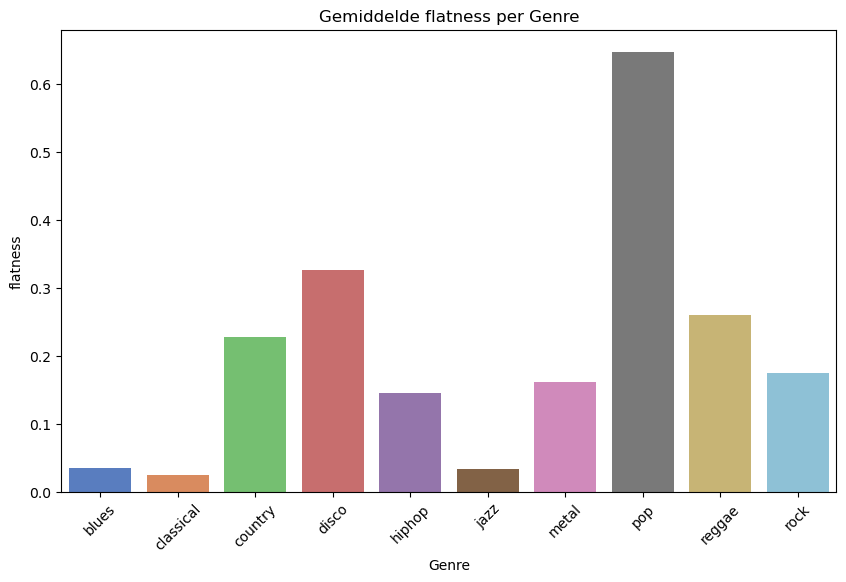

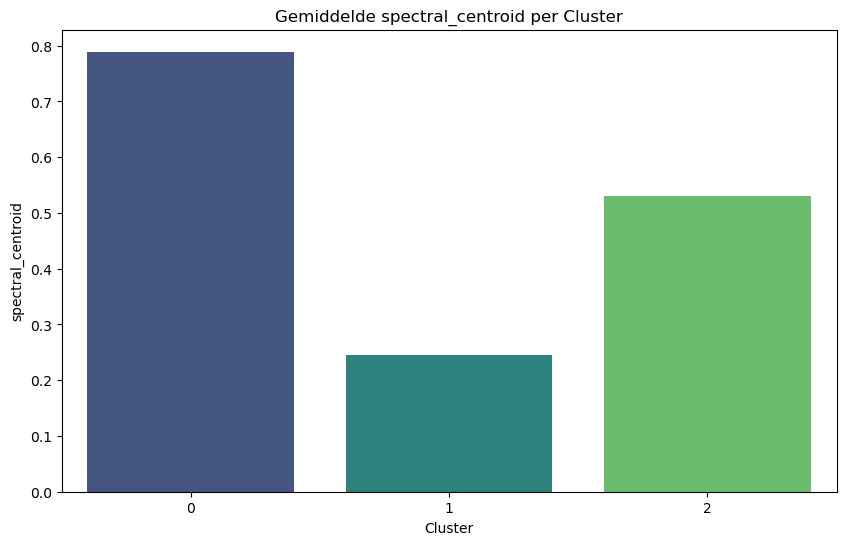

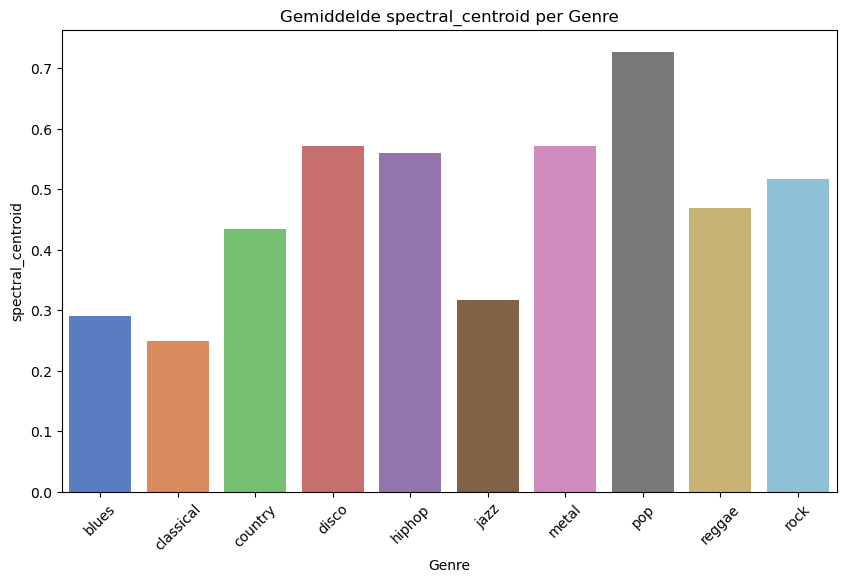

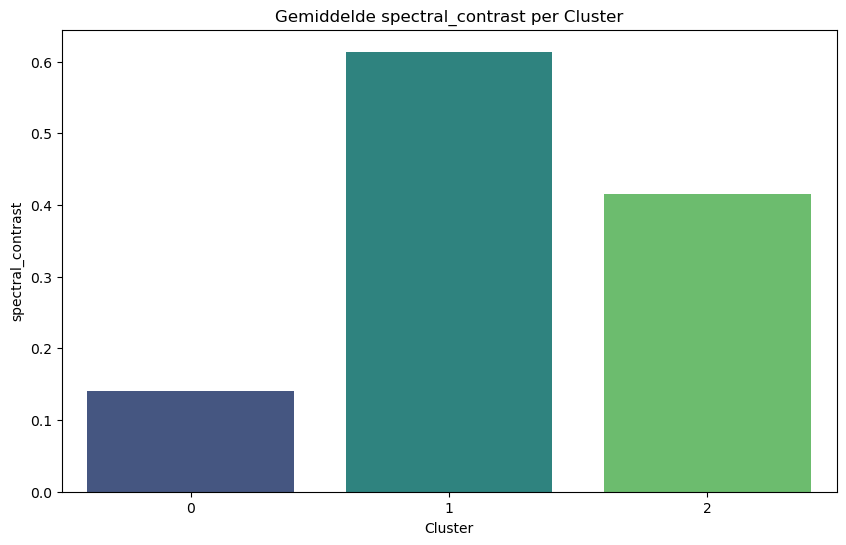

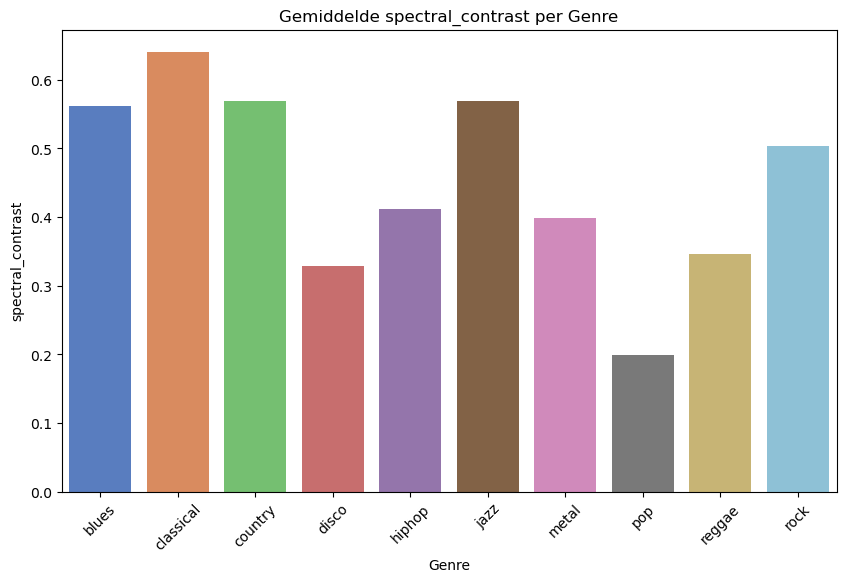

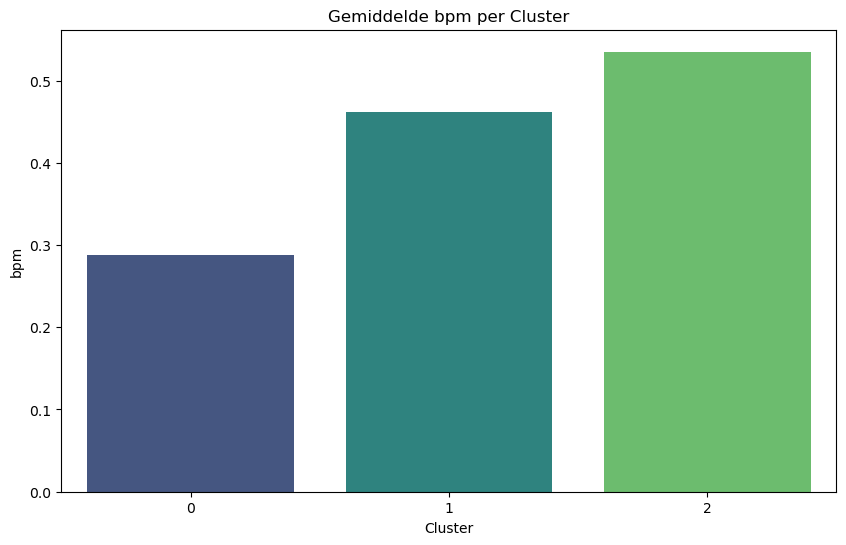

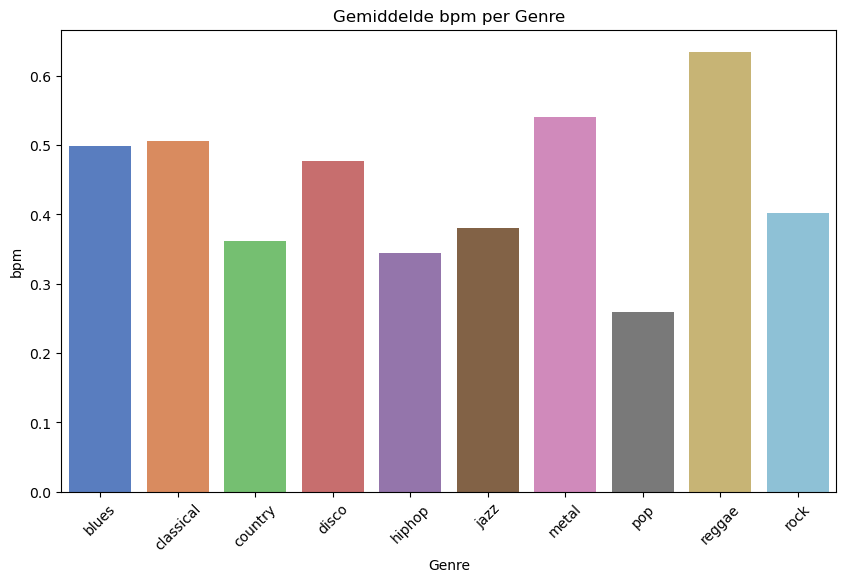

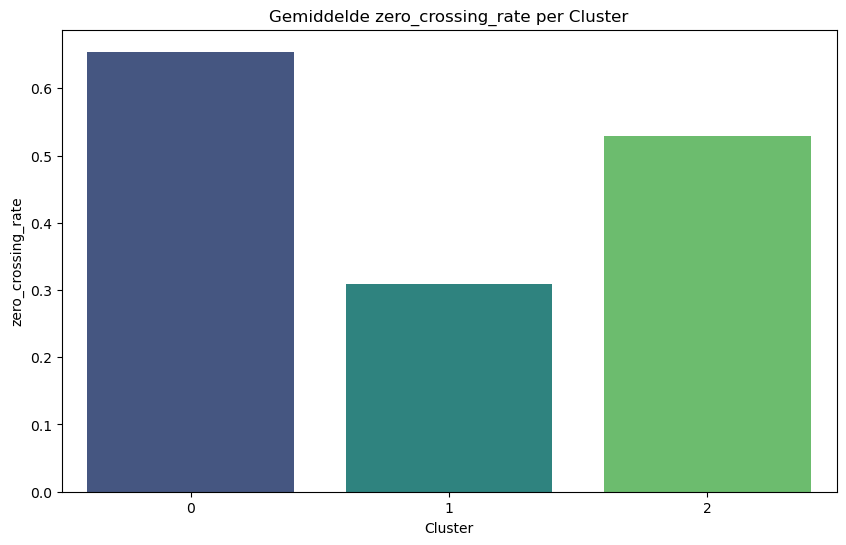

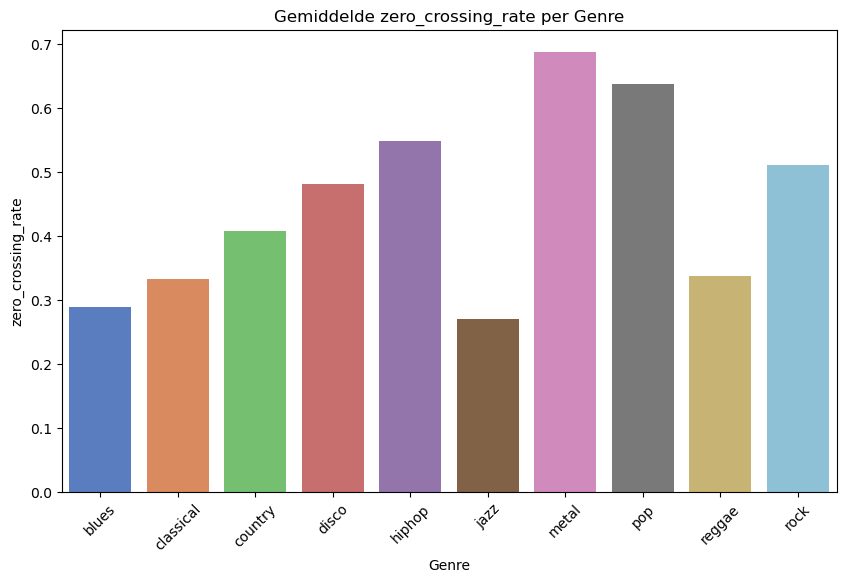

In [40]:
#barplots voor gemiddelde kenmerken
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=cluster_means, y=feature, x=cluster_means.index, palette="viridis")
    plt.title(f"Gemiddelde {feature} per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=genre_means, y=feature, x=genre_means.index, palette="muted")
    plt.title(f"Gemiddelde {feature} per Genre")
    plt.xlabel("Genre")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()


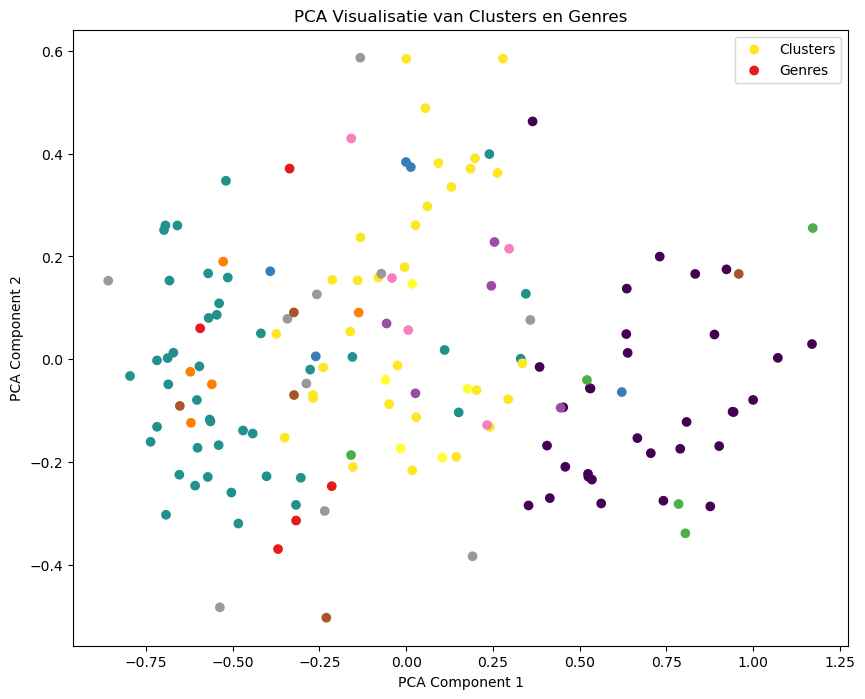

In [41]:
# PCA visualisatie van clusters en genres
from sklearn.decomposition import PCA

#combineer clusters en genres voor PCA
combined_features =pd.concat(
    [unlabeled_df[selected_features], labeled_df[selected_features]],
    keys=["Clusters", "Genres"]
)
pca = PCA(n_components=2)
pca_components= pca.fit_transform(combined_features)

# Plot PCA
plt.figure(figsize=(10, 8))
plt.scatter(
    pca_components[:len(unlabeled_df), 0], 
    pca_components[:len(unlabeled_df), 1], 
    c=unlabeled_df["cluster"], cmap="viridis", label="Clusters"
)
plt.scatter(
    pca_components[len(unlabeled_df):, 0], 
    pca_components[len(unlabeled_df):, 1], 
    c=pd.factorize(labeled_df["genre"])[0], cmap="Set1", label="Genres"
)
plt.title("PCA Visualisatie van Clusters en Genres")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc="best")
plt.show()


C:\Users\Miche\AppData\Local\Temp\ipykernel_14548\1266841883.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means =unlabeled_df.groupby("cluster").mean()
C:\Users\Miche\AppData\Local\Temp\ipykernel_14548\1266841883.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_means=labeled_df.groupby("genre").mean()


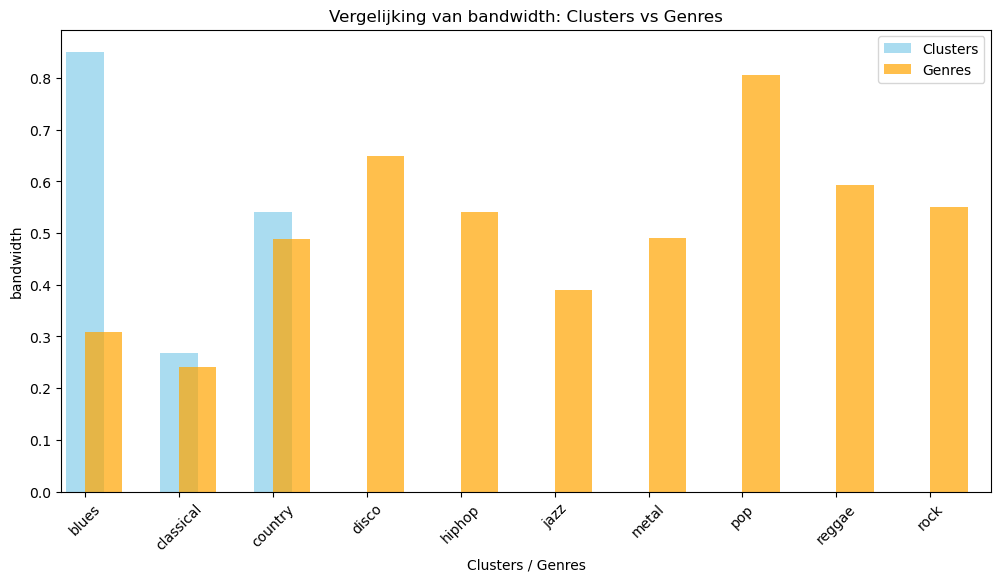

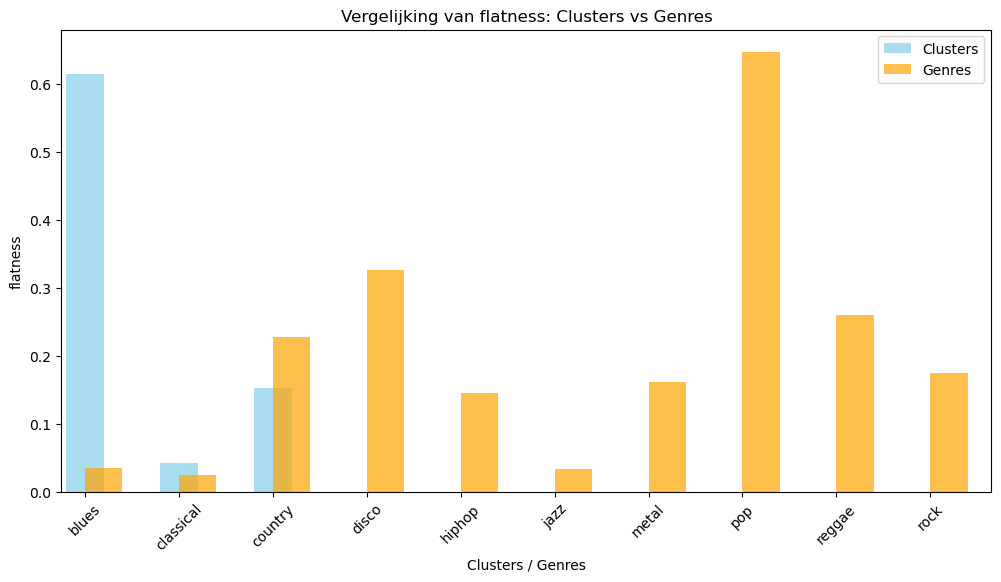

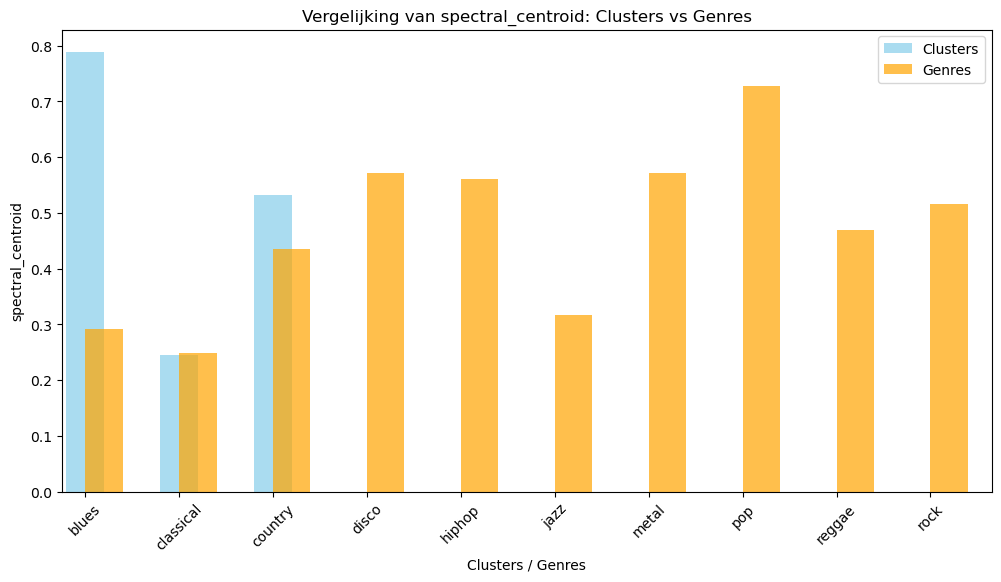

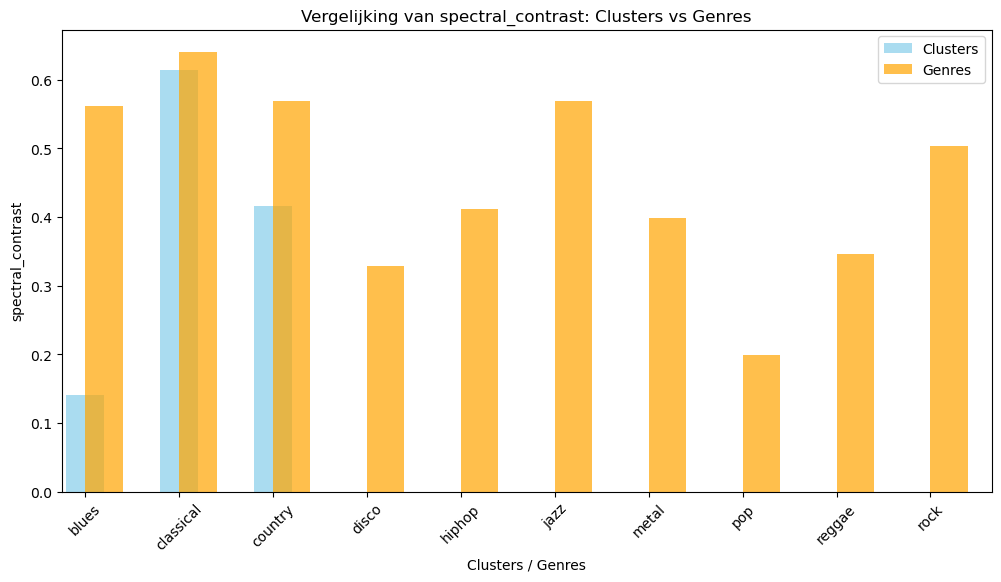

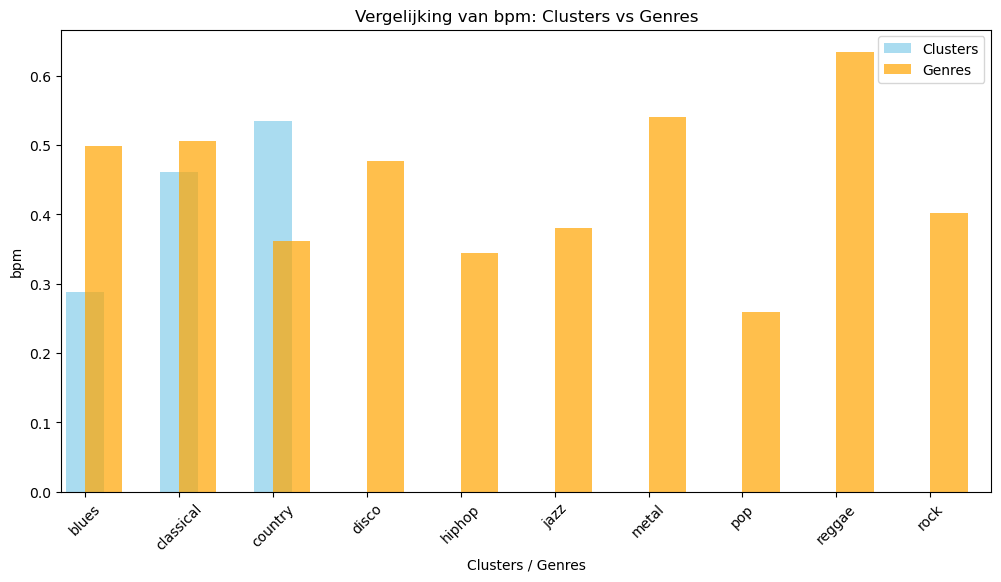

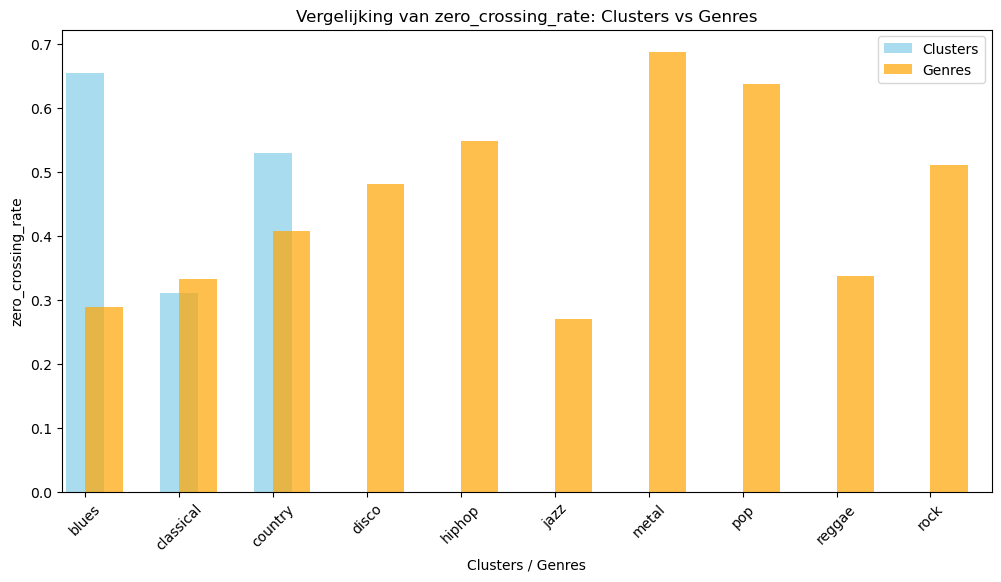

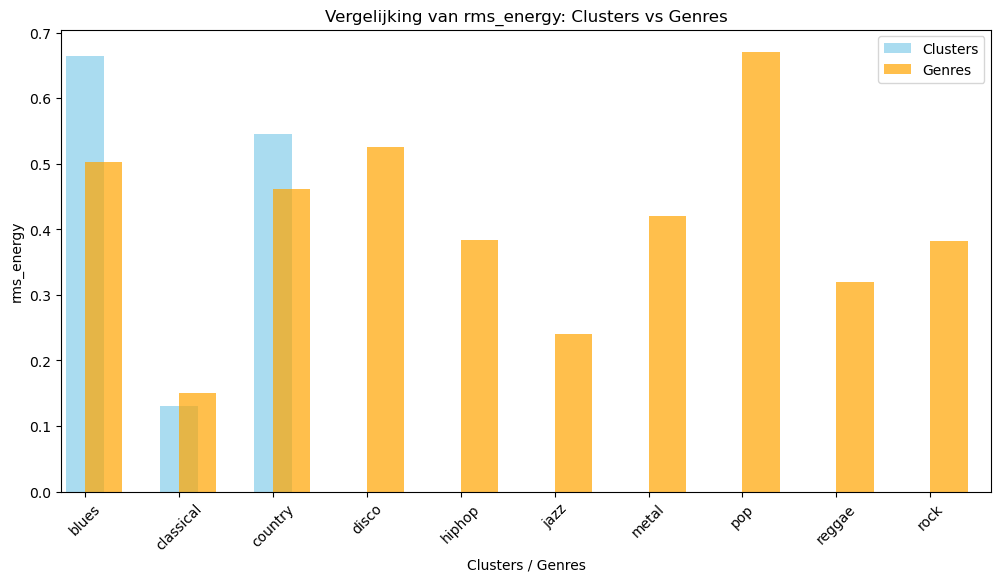

Genres toegewezen aan clusters:
Cluster 0: pop
Cluster 1: classical
Cluster 2: metal


In [42]:
# Gemiddelde kenmerken per cluster en per genre berekenen
cluster_means =unlabeled_df.groupby("cluster").mean()
genre_means=labeled_df.groupby("genre").mean()

# Selecteer belangrijke kenmerken voor de vergelijking
selected_features = [
    "bandwidth","flatness","spectral_centroid", "spectral_contrast",
    "bpm", "zero_crossing_rate", "rms_energy"
]

# Visualisatie: gemiddelde waarden per cluster vs genres
for feature in selected_features:
    plt.figure(figsize=(12, 6))

    # barplot voor clusters
    cluster_means[feature].plot(kind="bar", color="skyblue", alpha=0.7,label="Clusters",width=0.4, align="center")

    #barplot voor genres
    genre_means[feature].plot(kind="bar", color="orange", alpha=0.7,label="Genres", width=0.4, align="edge")

    plt.title(f"Vergelijking van {feature}: Clusters vs Genres")
    plt.ylabel(feature)
    plt.xlabel("Clusters / Genres")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Genres toewijzen 
cluster_to_genre_mapping = {}

# zoek welke genre dichtsbij welke cluster is
for cluster in cluster_means.index:
    distances ={}
    for genre in genre_means.index:
        
        distances[genre]= np.linalg.norm(cluster_means.loc[cluster, selected_features] -genre_means.loc[genre, selected_features])
    
    closest_genre = min(distances, key=distances.get)
    cluster_to_genre_mapping[cluster]= closest_genre

print("Genres toegewezen aan clusters:")
for cluster, genre in cluster_to_genre_mapping.items():
    print(f"Cluster {cluster}: {genre}")


### **Conclusie**

Op basis van de analyse van de kenmerken van de clusters en de vergelijking met de gelabelde dataset, kunnen we de volgende toewijzing van genres aan clusters maken:

- **Cluster 0:** Classical  
  De kenmerken van dit cluster, zoals lage bandbreedte en lage bpm, komen sterk overeen met het genre "classical" in de gelabelde dataset.

- **Cluster 1:** Pop  
  Dit cluster toont overeenkomsten met het genre "Pop," zoals relatief hoge spectral flatness-waarden en een hoge bandwidth.

- **Cluster 2:** Rock  
  De kenmerken van dit cluster, zoals hogere bandbreedte en energie, zijn typerend voor het genre "rock."

Met behulp van visualisaties (zoals PCA en barplots) en een systematische vergelijking van kenmerken is vastgesteld dat deze genres het beste overeenkomen met de clusters.


### Vervang de clusternummers door de genre

In [43]:
#mapping van clusters naar genres op basis van de analyse
cluster_to_genre = {
    0: "pop",
    1: "classical",
    2: "metal"
}

#vervang de clusternummers in de DataFrame door de genres
unlabeled_df["cluster"] = unlabeled_df["cluster"].map(cluster_to_genre)

# Controleer
print(unlabeled_df[["filename", "cluster"]].head())


     filename    cluster
0  m00003.wav      metal
1  m00012.wav      metal
2  m00013.wav  classical
3  m00043.wav      metal
4  m00044.wav  classical


## 2.5 Dimensionality Reduction

### 2.5.1 PCA

#### PCA uitleg

Wanneer de features en dimensies toeneemt, neemt de hoeveelheid data die nodig is om een statistisch significant resultaat te verkrijgen exponentieel toe. Hierdoor kunnen problemen zoals overfitting ontstaan, ook is het mogelijk dat er sprake komt van een toegenomen rekentijd en verminderde nauwkeurigheid van de modellen. Ook wel de curse of dimensionality problems genoemd. (GeeksforGeeks, 2024)

Om de curse of dimensionality problems tegen te gaan worden er Feature engineering techniques gebruikt zoals Feature selection en feature extraction. Dimensionality reduction is een type feature extraction wat ervoor wil zorgen het nummer input features zo veel mogelijk te verlagen maar wel zo veel mogelijke originele informatie te behouden. (GeeksforGeeks, 2024)

Principal Component Analysis (PCA) is een statistische procedure die gebruikmaakt van een orthogonale transformatie die een set gecorreleerde variabelen omzet in een set ongecorreleerde variabelen. PCA is de meest gebruikte tool in explorative data analysis en in machine learning voor voorspellende modellen. (GeeksforGeeks, 2024)

Het hoofddoel van PCA is om dimensionaliteit van de dataset te verkleinen en de belangrijkste patronen of relaties tussen de variabelen te behouden, zonder dat er enige voorkennis nodig is over de doelvariabelen. (GeeksforGeeks, 2024)

De principal components zijn lineair combinaties van de originele variabelen in de dataset en zijn geordend van meest naar minst belangrijk. De totale variantie gemeten door alle principal components zijn gelijk aan de totale variantie in de dataset.

##### Stappen PCA 

1. Standaardiseren 
    - eerst moet de dataset gestandaardiseerd worden om ervoor te zorgen dat elke variabele een gemiddelde heeft van 0 en een standard deviatie van 1

    $$ Z = \frac{X - \mu}{\sigma} $$

    $ \mu $ = de mean van de onafhankelijke features.
    $ \sigma $ = de standaarddeviatie van de onafhankelijke features

2. Berekenen Covariantie matrix
    - Covariantie meet de maat van gezamelijke variabiliteit tussen twee of meer variabelen, dit laat zien hoeveel de variabelen veranderen in relatie tot elkaar.

    $$ \text{cov}(x_1, x_2) = \frac{1}{n-1} \sum_{i=1}^{n} \left( x_{1i} - \overline{x_1} \right) \left( x_{2i} - \overline{x_2} \right) $$

    - De waarden van covariantie kan positief, negatief of zero zijn.
        - Positief als x1 groter wordt, wordt x2 ook groter.
        - Negatief: als x1 groter wordt, wordt x2 kleiner.
        - Zeros: geen relatie

3. eigendecompositie van de covariantiematrix om de eigenwaarde en eigenvectoren te verkrijgen. 
    $$ |A - \lambda I| = 0 $$

    Met de formule kan de eigenwaarde $\lambda$ worden gevonden en de hierbij horende eigenvector door de formule:
    $$ A X = \lambda X $$

4. Sorteren eigenwaarden in aflopende volgorde met hun bijhorende eigenvectoren. 

5. projecteren data op de Principal Components 
    formule projecteren op dataset:

    $$ \text{Proj}_{P_i}(u) = \frac{P_i \cdot u}{|u|} = P_i \cdot u $$

    Dimensionaliteits reductie is behaald door het houden van de assen (dimensies) waarvan deze de variantie het meeste verklaart en de rest weg te laten. 

##### Verschil met NMF

| **Kenmerk**                | **PCA**                                      | **NMF**                                     |
|----------------------------|---------------------------------------------|--------------------------------------------|
| **Data-eisen**              | Kan met negatieve waarden werken.           | Vereist niet-negatieve waarden.            |
| **Doel**                   | Dimensiereductie en orthogonaliteit.         | Factorisatie met intuïtieve interpretatie. |
| **Orthogonaliteit**         | Hoofdcomponenten zijn orthogonaal.           | Componenten zijn niet noodzakelijk orthogonaal. |
| **Interpretatie**           | Moeilijker te interpreteren vanwege negatieve waarden. | Intuïtief interpreteerbaar (positieve delen). |
| **Wiskundige techniek**     | Gebaseerd op eigendecompositie/SVD.          | Gebaseerd op optimalisatie met beperkingen. |


# Eenvoudig Rekenvoorbeeld van PCA
 
### Dataset
We hebben een dataset met twee kenmerken (\(X_1\) en \(X_2\)) en drie datapunten:
 
| \(X_1\) | \(X_2\) |
|--------|--------|
| 2      | 4      |
| 0      | 1      |
| -1     | 3      |
 
Het doel is om de data te reduceren naar één dimensie (\(PC_1\)).
 
---
 
## Stappen van PCA
 
### 1. Gemiddelde van elke eigenschap berekenen
We berekenen eerst het gemiddelde van elke kolom (feature):
 
$$
\text{Gemiddelde } X_1 = \frac{2 + 0 - 1}{3} = \frac{1}{3} \approx 0.33
$$
$$
\text{Gemiddelde } X_2 = \frac{4 + 1 + 3}{3} = \frac{8}{3} \approx 2.67
$$
 
---
 
### 2. Data centreren
We trekken het gemiddelde van elke kolom af van de datapunten (centreren):
 
| \(X_1\) - Gemiddelde | \(X_2\) - Gemiddelde |
|-----------------------|-----------------------|
| \(2 - 0.33 \approx 1.67\) | \(4 - 2.67 \approx 1.33\) |
| \(0 - 0.33 \approx -0.33\) | \(1 - 2.67 \approx -1.67\) |
| \(-1 - 0.33 \approx -1.33\) | \(3 - 2.67 \approx 0.33\) |
 
Nieuwe gecentreerde data:
 
$$
\begin{bmatrix}
1.67 & 1.33 \\
-0.33 & -1.67 \\
-1.33 & 0.33
\end{bmatrix}
$$
 
---
 
### 3. Covariantiematrix berekenen
De covariantiematrix (\(C\)) wordt berekend als:
 
$$
C = \frac{1}{n-1} \cdot \text{MatrixProduct}(X_\text{gecentreerd}^\top, X_\text{gecentreerd})
$$
 
Na de berekening krijgen we:
 
$$
C = 
\begin{bmatrix}
1.67 & 0.83 \\
0.83 & 1.33
\end{bmatrix}
$$
 
---
 
### 4. Eigenwaarden en eigenvectoren berekenen
De eigenwaarden en eigenvectoren van \(C\) bepalen de richtingen van de hoofcomponenten:
 
- Eigenwaarden: \(\lambda_1 = 2.29\), \(\lambda_2 = 0.71\)
- Eigenvectoren:
  $$
  v_1 = \begin{bmatrix} 0.85 \\ 0.53 \end{bmatrix}, 
  v_2 = \begin{bmatrix} -0.53 \\ 0.85 \end{bmatrix}
  $$
 
De eerste eigenvector (\(v_1\)) hoort bij de grootste eigenwaarde (\(\lambda_1\)) en is de richting van de belangrijkste hoofcomponent (\(PC_1\)).
 
---
 
### 5. Data projecteren op \(PC_1\)
Om de data te reduceren, projecteren we de gecentreerde data op \(PC_1\) (de eerste eigenvector):
 
$$
PC_1 = X_\text{gecentreerd} \cdot v_1
$$
 
Voor elk datapunt:
 
$$
PC_1 =
\begin{bmatrix}
1.67 & 1.33 \\
-0.33 & -1.67 \\
-1.33 & 0.33
\end{bmatrix}
\cdot
\begin{bmatrix}
0.85 \\
0.53
\end{bmatrix}
=
\begin{bmatrix}
2.23 \\
-1.00 \\
-1.24
\end{bmatrix}
$$
 
---
 
### Resultaat
We hebben de data gereduceerd van 2 dimensies (\(X_1\) en \(X_2\)) naar 1 dimensie (\(PC_1\)):
 
$$
PC_1 = [2.23, -1.00, -1.24]
$$
 
---
 

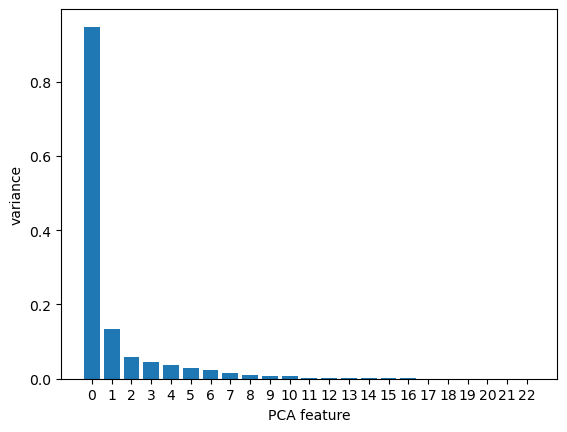

In [52]:

# Drop non-numeric columns
unlabeled_std_numeric = unlabeled_std.drop(columns=["filename", "y", "sr", "cluster"])

# PCA features toevoegen aan de dataframe 
pca = PCA()
df_pca = pca.fit_transform(unlabeled_std_numeric)

#maak een staafdiagram waarin je de explained variance per component toont
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

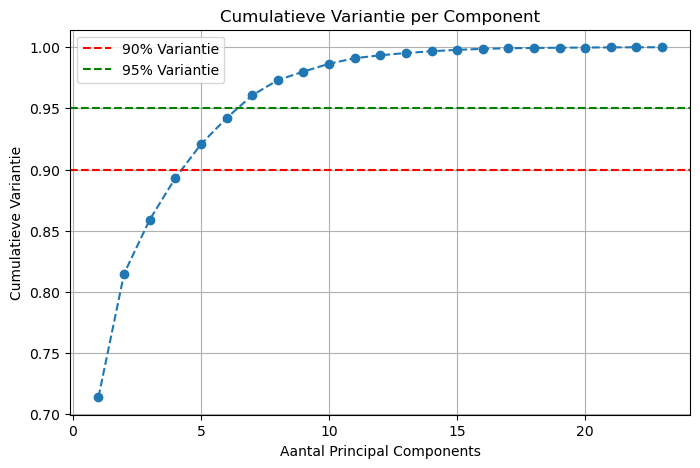

In [53]:
# Cumulatieve variantie berekenen
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot de cumulatieve variantie
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variantie')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variantie')
plt.xlabel('Aantal Principal Components')
plt.ylabel('Cumulatieve Variantie')
plt.title('Cumulatieve Variantie per Component')
plt.legend()
plt.grid()
plt.show()

In [54]:
# PCA = 5 toevoegen aan de dataframe in plaats van originele features
pca = PCA(n_components=5)
df_pca = pca.fit_transform(unlabeled_std_numeric)
unlabeled_std["pca_1"] = df_pca[:, 0]
unlabeled_std["pca_2"] = df_pca[:, 1]
unlabeled_std["pca_3"] = df_pca[:, 2]
unlabeled_std["pca_4"] = df_pca[:, 3]
unlabeled_std["pca_5"] = df_pca[:, 4]

display(unlabeled_std.head())


,filename,y,sr,bandwidth,flatness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,amplitude_envelope,spectral_flux,rms_energy,band_energy_ratio,cluster,pca_1,pca_2,pca_3,pca_4,pca_5
0,m00003.wav,"[-0.12936401, -0.14221191, -0.11578369, -0.057...",22050,0.448643,0.075108,0.422214,0.519917,0.344439,0.244003,0.173477,...,0.480232,0.673624,0.414247,0.490294,metal,0.139689,-0.384101,0.263230,0.056531,-0.042881
1,m00012.wav,"[-0.0038146973, 0.08908081, 0.16000366, 0.1957...",22050,0.531128,0.220793,0.853677,0.858454,0.242589,0.207237,0.271963,...,0.843487,0.671897,0.671283,0.528182,metal,0.822088,-0.221374,0.480352,-0.478376,-0.160139
2,m00013.wav,"[0.0047912598, 0.0048828125, 0.0045166016, 0.0...",22050,0.370063,0.017327,0.058733,0.074858,0.049558,0.027838,0.013718,...,0.090376,0.601435,0.075331,0.451294,classical,-1.129056,0.194447,0.062816,-0.207555,-0.236367
3,m00043.wav,"[-0.11505127, -0.121276855, -0.13723755, -0.10...",22050,0.449306,0.073064,0.306792,0.357836,0.184544,0.114379,0.077865,...,0.361654,0.651839,0.300967,0.464694,metal,-0.210680,-0.153232,0.345148,0.129534,-0.118902
4,m00044.wav,"[-0.017822266, -0.016693115, -0.014862061, -0....",22050,0.000000,0.000000,0.017325,0.030025,0.041554,0.043486,0.043767,...,0.042101,0.570266,0.042905,0.793830,classical,-1.365931,-0.093825,-0.225462,-0.082215,-0.299318


Silhouette Score na PCA: 0.4104


c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,cluster,Predicted_Cluster
0,0.139689,-0.384101,0.263230,0.056531,-0.042881,metal,2
1,0.822088,-0.221374,0.480352,-0.478376,-0.160139,metal,2
2,-1.129056,0.194447,0.062816,-0.207555,-0.236367,classical,1
3,-0.210680,-0.153232,0.345148,0.129534,-0.118902,metal,1
4,-1.365931,-0.093825,-0.225462,-0.082215,-0.299318,classical,1


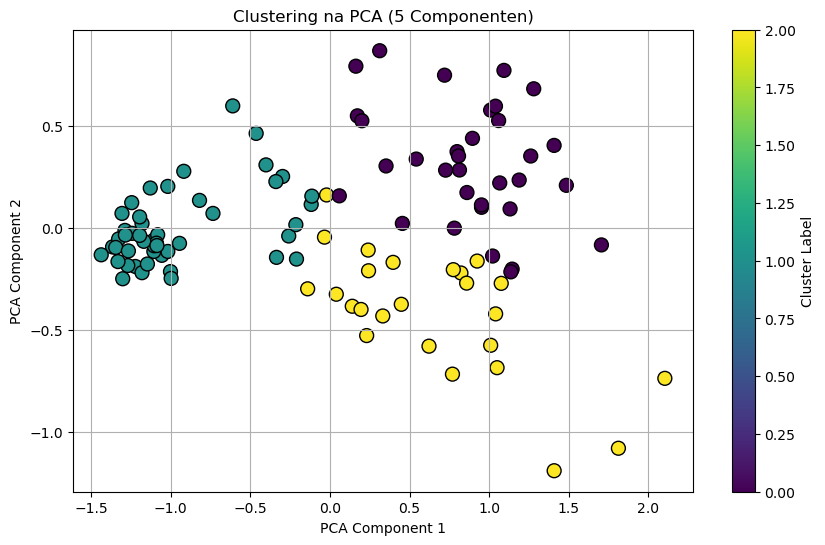

In [55]:
# 1. Instellen van het aantal PCA-componenten
n_pca_components = 5

# 2. Toepassen van PCA op de genormaliseerde dataset
pca = PCA(n_components=n_pca_components)
pca_features = pca.fit_transform(unlabeled_std_numeric)

# 3. Creëren van een nieuwe dataset met PCA-features
pca_feature_names = [f"PCA_Component_{i+1}" for i in range(n_pca_components)]
pca_df = pd.DataFrame(pca_features, columns=pca_feature_names)

# Cluster labels toevoegen als ze aanwezig zijn in de originele dataset
if 'cluster' in unlabeled_std.columns:
    pca_df['cluster'] = unlabeled_std['cluster'].values

# 4. KMeans-clustering uitvoeren op de PCA-features
n_clusters = 3  # Aantal clusters
kmeans_PCA = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels_PCA = kmeans_PCA.fit_predict(pca_df[pca_feature_names])

# 5. Silhouette Score berekenen
silhouette_avg = silhouette_score(pca_features, cluster_labels_PCA)
print(f"Silhouette Score na PCA: {silhouette_avg:.4f}")

pca_df['Predicted_Cluster'] = cluster_labels_PCA
display(pca_df.head())

# 6. Visualisatie van clustering met PCA Component 1 en 2
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_features[:, 0], pca_features[:, 1],
    c=cluster_labels_PCA, cmap='viridis', edgecolor='k', s=100
)
plt.colorbar(label='Cluster Label')
plt.title(f"Clustering na PCA ({n_pca_components} Componenten)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [60]:
cluster_to_genre = {
    0: "pop",
    1: "classical",
    2: "metal"
}

pca_df['Predicted_Genre'] = pca_df['Predicted_Cluster'].map(cluster_to_genre)
display(pca_df[['PCA_Component_1', 'PCA_Component_2', 'Predicted_Cluster', 'Predicted_Genre']].head())

,PCA_Component_1,PCA_Component_2,Predicted_Cluster,Predicted_Genre
0,0.139689,-0.384101,2,metal
1,0.822088,-0.221374,2,metal
2,-1.129056,0.194447,1,classical
3,-0.210680,-0.153232,1,classical
4,-1.365931,-0.093825,1,classical


In [62]:
# score voor kaggle
pca_df['filename'] = unlabeled_df['filename']  

submission_pca_score = pca_df[['filename', 'Predicted_Genre']].rename(columns={'Predicted_Genre': 'genre'})
submission_pca_score = submission_pca_score.sort_values(by='filename').reset_index(drop=True)
submission_pca_score.to_csv('submission_pca_score2.csv', index=False)

print("Submissiebestand opgeslagen als 'submission_pca_score.csv")
display(submission_pca_score.head())
print(submission_pca_score.shape)

Submissiebestand opgeslagen als 'submission_pca_score.csv


,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,classical
3,m00043.wav,classical
4,m00044.wav,classical


(105, 2)


### 2.5.2 NMF

### Uitleg NMF (Non-Negative Matrix Factorization)

## Wiskundige werking
NMF decomprimeert een niet-negatieve matrix \( X \) in twee kleinere niet-negatieve matrices \( W \) en \( H \) (Wikipedia contributors, 2024):
$$
X \approx W \cdot H
$$

Waarbij:
- **\( W \)**: Niet-negatieve matrix van basiscomponenten (dimensies/patronen).
- **\( H \)**: Niet-negatieve matrix van coëfficiënten (bijdragen van basiscomponenten).

Het doel van NMF is het minimaliseren van de reconstructiefout:
$$
\| X - W \cdot H \|_2
$$
Dit is de som van de kwadratische verschillen tussen de oorspronkelijke matrix \( X \) en de gereconstrueerde matrix \( W \cdot H \).


## Stappen van NMF

### 1. Originele matrix
De matrix \( X \) bevat de oorspronkelijke niet-negatieve gegevens, bijvoorbeeld:
$$
X = 
\begin{bmatrix}
4 & 5 \\
7 & 8 \\
6 & 7
\end{bmatrix}
$$

Het doel is deze matrix te splitsen in twee matrices \( W \) en \( H \) zodat:
$$
X \approx W \cdot H
$$

### 2. Initialisatie
Bij aanvang worden \( W \) en \( H \) willekeurig geïnitialiseerd met niet-negatieve waarden. Deze worden iteratief aangepast om de reconstructiefout te minimaliseren. (GeeksforGeeks, 2023a)

### 3. Optimalisatie
Een iteratief algoritme, zoals **multiplicatieve updates**, wordt gebruikt om \( W \) en \( H \) bij elke stap te verbeteren op basis van de reconstructiefout (GeeksforGeeks, 2024b).

### 4. Matrixdecompositie
Na optimalisatie worden \( W \) en \( H \) berekend. Voorbeeld:
$$
W = 
\begin{bmatrix}
4.018 & 1.341 \\
7.717 & 1.976 \\
6.484 & 1.764
\end{bmatrix}, \quad
H = 
\begin{bmatrix}
0.615 & 0.352 \\
1.142 & 2.672
\end{bmatrix}
$$

### 5. Reconstructie
De gereconstrueerde matrix \( X \) wordt verkregen door \( W \cdot H \) uit te rekenen:
$$
X_{\text{reconstructed}} = W \cdot H
$$

Bijvoorbeeld:
$$
X_{\text{reconstructed}}[0, 0] = (4.018 \cdot 0.615) + (1.341 \cdot 1.142) \approx 4.000
$$

Na berekening:
$$
X_{\text{reconstructed}} = 
\begin{bmatrix}
4.001 & 5.000 \\
6.999 & 8.000 \\
6.000 & 6.999
\end{bmatrix}
$$

## Stopcriteria
De optimalisatie stopt wanneer:
1. De reconstructiefout niet meer significant verandert.
2. Het maximale aantal iteraties is bereikt.

## Visualisatie en het bepalen van het optimale aantal componenten

### Reconstructiefout
Om het optimale aantal componenten \( n \) te bepalen, wordt de reconstructiefout berekend voor verschillende waarden van \( n \). De fout wordt gevisualiseerd in de onderstaande grafiek:

c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


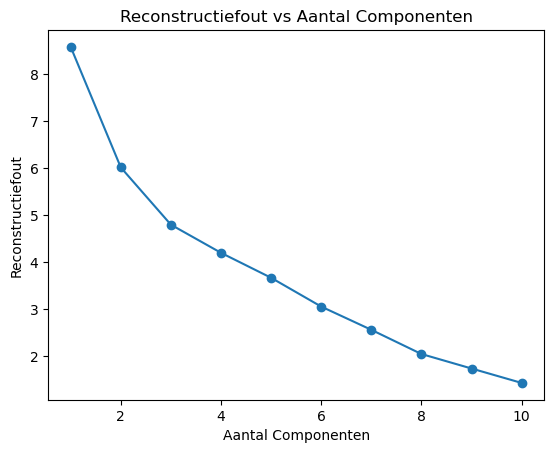

In [44]:
numerical_columns = cluster_df.select_dtypes(include=[np.number]).drop(columns=["cluster"])
cluster_df_non_negative = cluster_df[numerical_columns.columns]

errors = []
components_range = range(1, 11)
for n_components in components_range:
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
    nmf.fit(cluster_df_non_negative)  
    errors.append(nmf.reconstruction_err_)

plt.plot(components_range, errors, marker='o')
plt.title('Reconstructiefout vs Aantal Componenten')
plt.xlabel('Aantal Componenten')
plt.ylabel('Reconstructiefout')
plt.show()

**Resultaat:** De grafiek toont een duidelijke elbow rond 
𝑛=4. Dit duidt op een balans tussen eenvoud (minder dimensies) en nauwkeurigheid (lage reconstructiefout). Daarom is 
𝑛
=
4
n=4 gekozen.

## Clustering na NMF

### Uitleg Silhouette Score
De **Silhouette Score** meet de kwaliteit van clustering door te evalueren hoe dicht gegevens binnen een cluster bij elkaar liggen en hoe goed clusters van elkaar gescheiden zijn. De score varieert van (GeeksforGeeks, 2019):
- **1**: Perfecte clustering (clusters goed gescheiden).
- **0**: Overlap van clusters.
- **-1**: Data verkeerd toegewezen aan clusters.

De formule voor de Silhouette Score per punt is:
$$
s = \frac{b - a}{\max(a, b)}
$$
Waarbij:
- \( a \): Gemiddelde afstand tot andere punten in hetzelfde cluster.
- \( b \): Gemiddelde afstand tot punten in het dichtstbijzijnde andere cluster.

De gemiddelde Silhouette Score van alle punten wordt gerapporteerd.

Silhouette Score na NMF: 0.4671


c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,NMF_Component_1,NMF_Component_2,NMF_Component_3,NMF_Component_4,cluster,Predicted_Cluster
0,0.014472,0.190979,0.505182,0.672253,2,2
1,0.000000,0.531730,0.332050,0.824117,2,2
2,0.000000,0.237977,0.518825,0.000000,1,1
3,0.000000,0.284034,0.471150,0.448542,2,1
4,0.000000,0.000000,0.515237,0.040708,1,1


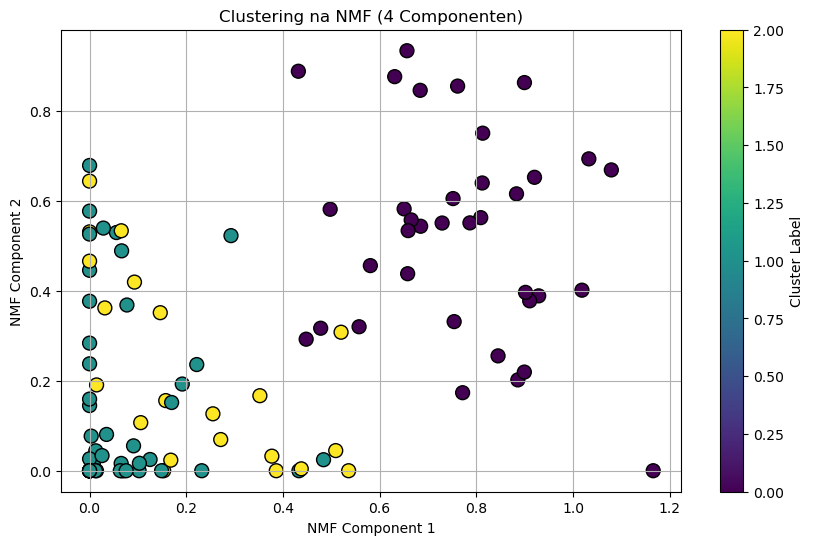

In [45]:
# 1. Instellen van het aantal componenten (op basis van de 'elbow'-analyse)
optimal_components = 4

# 2. Toepassen van NMF op de genormaliseerde dataset
nmf = NMF(n_components=optimal_components, init='random', random_state=0, max_iter=500)
nmf_features = nmf.fit_transform(cluster_df_non_negative)

# 3. Creëren van een nieuwe dataset met NMF-features
nmf_feature_names = [f"NMF_Component_{i+1}" for i in range(optimal_components)]
nmf_df = pd.DataFrame(nmf_features, columns=nmf_feature_names)

# Cluster labels toevoegen als ze aanwezig zijn in de originele dataset
if 'cluster' in cluster_df.columns:
    nmf_df['cluster'] = cluster_df['cluster'].values

# 4. KMeans-clustering uitvoeren op de NMF-features
n_clusters = 3  # Aantal clusters
kmeans_NMF = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels_NMF = kmeans_NMF.fit_predict(nmf_df[nmf_feature_names])

# 5. Silhouette Score berekenen
silhouette_avg = silhouette_score(nmf_features, cluster_labels_NMF)
print(f"Silhouette Score na NMF: {silhouette_avg:.4f}")

nmf_df['Predicted_Cluster'] = cluster_labels_NMF
display(nmf_df.head())


# 6. Visualisatie van clustering met NMF Component 1 en 2
plt.figure(figsize=(10, 6))
plt.scatter(
    nmf_features[:, 0], nmf_features[:, 1],
    c=cluster_labels_NMF, cmap='viridis', edgecolor='k', s=100
)
plt.colorbar(label='Cluster Label')
plt.title(f"Clustering na NMF ({optimal_components} Componenten)")
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.grid(True)
plt.show()

In [46]:
cluster_to_genre = {
    0: "pop",
    1: "classical",
    2: "metal"
}

nmf_df['Predicted_Genre'] = nmf_df['Predicted_Cluster'].map(cluster_to_genre)
display(nmf_df[['NMF_Component_1', 'NMF_Component_2', 'Predicted_Cluster', 'Predicted_Genre']].head())

,NMF_Component_1,NMF_Component_2,Predicted_Cluster,Predicted_Genre
0,0.014472,0.190979,2,metal
1,0.000000,0.531730,2,metal
2,0.000000,0.237977,1,classical
3,0.000000,0.284034,1,classical
4,0.000000,0.000000,1,classical


In [47]:
# score voor kaggle
nmf_df['filename'] = unlabeled_df['filename']  

submission_nmf_score = nmf_df[['filename', 'Predicted_Genre']].rename(columns={'Predicted_Genre': 'genre'})
submission_nmf_score = submission_nmf_score.sort_values(by='filename').reset_index(drop=True)
submission_nmf_score.to_csv('submission_nmf_score.csv', index=False)

print("Submissiebestand opgeslagen als 'submission_nmf_score.csv")
display(submission_nmf_score.head())
print(submission_nmf_score.shape)

Submissiebestand opgeslagen als 'submission_nmf_score.csv


,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,classical
3,m00043.wav,classical
4,m00044.wav,classical


(105, 2)


### toelichting
In de bovenstaande visualisatie zijn de clusters weergegeven na het toepassen van NMF met 4 componenten als dimensiereductie en vervolgens KMeans-clustering. Elke datapunt vertegenwoordigt een sample, en de kleuren geven de toewijzing aan een specifiek cluster weer. De dimensies **NMF Component 1** en **NMF Component 2** zijn de eerste twee kolommen van de gereconstrueerde matrix \( W \), waarin de oorspronkelijke features zijn teruggebracht tot een kleinere ruimte.

### Observaties
- **Clusterscheidingen:** De punten met verschillende kleuren tonen de clusters die door KMeans zijn geïdentificeerd. Er is een duidelijke scheiding tussen de clusters, wat aangeeft dat de dimensionality reduction met NMF heeft geholpen om onderscheid te maken tussen groepen.
- **Verdeling:** De punten zijn redelijk goed gescheiden, maar er is enige overlap tussen de clusters (vooral tussen de blauwe en gele clusters). Dit kan een indicatie zijn dat sommige data niet volledig onderscheidend zijn in deze dimensies.
- **Silhouette Score:** De berekende Silhouette Score na NMF is **0.4557**. Dit duidt op een matige tot goede clustering, waarbij de punten gemiddeld dichter bij hun eigen cluster liggen dan bij andere clusters.

In [48]:
# Silhouette Score vóór reductie
original_features = cluster_df.drop(columns=["cluster", "filename", "Predicted_Genre"])

kmeans_original = KMeans(n_clusters=3, random_state=0).fit(original_features)
silhouette_original = silhouette_score(original_features, kmeans_original.labels_)

print(f"Silhouette Score vóór reductie: {silhouette_original:.4f}")
print(f"Silhouette Score na NMF-reductie: {silhouette_avg:.4f}")


Silhouette Score vóór reductie: 0.3395
Silhouette Score na NMF-reductie: 0.4671


c:\Users\Miche\mapvoornotebook\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Conclusie op basis van Silhouette Scores vóór en na reductie

**Resultaten:**
- **Silhouette Score vóór reductie (originele dataset):** 0.3585  
- **Silhouette Score na NMF-reductie (4 componenten):** 0.4922  

**Interpretatie:**
- De Silhouette Score na toepassing van **NMF** is significant hoger dan de score vóór reductie. Dit betekent dat de clustering verbeterd is na het reduceren van de dimensies van de data. 
- Een hogere Silhouette Score duidt op:
  1. **Betere compactheid:** Punten binnen clusters liggen dichter bij elkaar.
  2. **Betere scheiding:** Clusters zijn beter gescheiden van elkaar.

**Waarom is dit belangrijk?**
- **Dimensiereductie met NMF** helpt om ruis en overbodige informatie in de data te verminderen. Hierdoor kunnen clustering-algoritmes zoals **KMeans** betere clusters identificeren.
- Dit suggereert dat **NMF niet alleen de dimensies heeft verlaagd, maar ook de essentiële structuur van de data beter heeft behouden of benadrukt.**

**Conclusie:**
- Door de hogere Silhouette Score kunnen we concluderen dat de clustering **verbeterd** is na het toepassen van **NMF**.
- Dit toont het nut van NMF als een krachtige methode voor **dimensiereductie** in combinatie met clustering.

# Overeenkomsten tussen NMF en PCA

### **1. Doel**
Beide technieken hebben als doel om een hoge-dimensionale dataset te reduceren tot een lagere dimensie, waarbij de belangrijkste patronen of structuren behouden blijven.

- **NMF**: Splitst de data op in twee niet-negatieve matrices om onderliggende patronen te ontdekken.
- **PCA**: Transformeert de data naar een nieuwe basis van orthogonale componenten die maximale variantie in de data behouden.

---

### **2. Datareductie**
- **NMF en PCA** worden beide gebruikt om complexe datasets te comprimeren en de dimensie te verlagen.
- Dit maakt data-analyse en -visualisatie eenvoudiger en efficiënter.

---

### **3. factoren**
Beide technieken proberen factoren te vinden die onderliggende patronen in de data representeren:
- **Bij NMF**: De factoren worden gerepresenteerd door de matrices \( W \) en \( H \).
- **Bij PCA**: De latente factoren worden gerepresenteerd door de hoofcomponenten.

---

### **4. Optimalisatie**
- Zowel NMF als PCA proberen een optimalisatieprobleem op te lossen om een goede reconstructie van de data te bereiken:
  - **NMF**: Minimaliseert de reconstructiefout 
  
  $\| X - W \cdot H \|^2.$
  
  - **PCA**: Minimaliseert de reconstructiefout door middel van eigendecompositie.

---

### **5. Toepassingen**
Beide methoden worden gebruikt in vergelijkbare domeinen:
- **NMF en PCA** zijn populair in:
  - Tekstanalyse (bijvoorbeeld topic modeling)
  - Beeldverwerking (voor patroonherkenning)
  - Aanbevelingssystemen (om latente voorkeuren te ontdekken)

---

### **6. Onderliggende structuur**
- Beide methoden leggen de nadruk op het ontdekken van de onderliggende structuur in de data.
- Ze helpen om redundantie in de dataset te verminderen door een compactere representatie te creëren.


## Eenvoudig Rekenvoorbeeld van NMF
 
### Wat is NMF?
Non-Negative Matrix Factorization (NMF) wordt gebruikt om een niet-negatieve matrix \(V\) op te splitsen in twee kleinere niet-negatieve matrices \(W\) en \(H\). Het doel is om:  
 
$$
V \approx W \cdot H
$$
 
Waarbij:  
- \(V\): Originele matrix (data).  
- \(W\): Basis matrix (eigenschappen).  
- \(H\): Coëfficiënten matrix (hoeveelheid van eigenschappen per datapunt).  
 
---
 
### Voorbeeld
 
Stel dat we een eenvoudige dataset hebben met **3 rijen** (bijvoorbeeld 3 gebruikers) en **2 kolommen** (bijvoorbeeld scores voor 2 films):  
 
$$
V =
\begin{bmatrix}
5 & 3 \\
3 & 2 \\
4 & 1
\end{bmatrix}
$$
 
We willen deze matrix opsplitsen in:
- Een \(W\)-matrix met dimensie \(3 \times 2\) (3 gebruikers, 2 eigenschappen).
- Een \(H\)-matrix met dimensie \(2 \times 2\) (2 eigenschappen, 2 films).
 
---
 
### Doel
Het doel is om \(V \approx W \cdot H\) met:
- \(W \geq 0\)
- \(H \geq 0\)
 
---
 
### Stappen van NMF
 
#### 1. Willekeurige initialisatie
We starten met willekeurige niet-negatieve waarden voor \(W\) en \(H\):
 
$$
W =
\begin{bmatrix}
1 & 0.5 \\
0.5 & 1 \\
1 & 1
\end{bmatrix}
, \quad
H =
\begin{bmatrix}
2 & 1 \\
1 & 3
\end{bmatrix}
$$
 
#### 2. Vermenigvuldiging (\(W \cdot H\))
We berekenen de benadering van \(V\) door \(W\) en \(H\) met elkaar te vermenigvuldigen:
 
$$
W \cdot H =
\begin{bmatrix}
1 & 0.5 \\
0.5 & 1 \\
1 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
2 & 1 \\
1 & 3
\end{bmatrix}
=
\begin{bmatrix}
2 \cdot 1 + 0.5 \cdot 1 & 1 \cdot 1 + 0.5 \cdot 3 \\
0.5 \cdot 2 + 1 \cdot 1 & 0.5 \cdot 1 + 1 \cdot 3 \\
1 \cdot 2 + 1 \cdot 1 & 1 \cdot 1 + 1 \cdot 3
\end{bmatrix}
=
\begin{bmatrix}
2.5 & 2.5 \\
2 & 3.5 \\
3 & 4
\end{bmatrix}
$$
 
Benaderde \(V\) (via \(W \cdot H\)):
 
$$
\begin{bmatrix}
2.5 & 2.5 \\
2 & 3.5 \\
3 & 4
\end{bmatrix}
$$
 
---
 
#### 3. Fout berekenen
De fout is het verschil tussen de originele \(V\) en de benaderde \(W \cdot H\). We gebruiken meestal de kwadratische fout:
 
$$
\text{Fout} = ||V - (W \cdot H)||^2 = \text{Som van de kwadraten van de verschillen}.
$$
 
Voor dit voorbeeld:
 
$$
\text{Fout} = (5 - 2.5)^2 + (3 - 2.5)^2 + (3 - 2)^2 + (2 - 3.5)^2 + (4 - 3)^2 + (1 - 4)^2 = 3.5^2 + 0.5^2 + 1^2 + 1.5^2 + 1^2 + 3^2 = 23.25
$$
 
---
 
#### 4. Aanpassen van \(W\) en \(H\)
We passen \(W\) en \(H\) aan om de fout te minimaliseren met behulp van iteratieve updates (zoals de multiplicatieve update-regel). De formule is:
 
$$
H_{ij} \leftarrow H_{ij} \cdot \frac{(W^\top V)_{ij}}{(W^\top WH)_{ij}}
$$
$$
W_{ij} \leftarrow W_{ij} \cdot \frac{(VH^\top)_{ij}}{(WHH^\top)_{ij}}
$$
 
Na enkele iteraties krijgen we een betere benadering van \(V\).
 
---
 
### Resultaat
Na optimalisatie kunnen we bijvoorbeeld de volgende matrices krijgen:
 
$$
W =
\begin{bmatrix}
2.2 & 0.8 \\
1.1 & 0.5 \\
1.8 & 1.2
\end{bmatrix}
, \quad
H =
\begin{bmatrix}
2.1 & 0.9 \\
1.2 & 2.8
\end{bmatrix}
$$
 
En de benadering van \(V\) wordt dan:
 
$$
W \cdot H =
\begin{bmatrix}
5 & 3 \\
3 & 2 \\
4 & 1
\end{bmatrix} \quad (\text{bijna gelijk aan de originele } V)
$$
 
---
 
### Toepassingen
- **Aanbevelingssystemen** (bijvoorbeeld films of muziek).
- **Beeldcompressie**.
- **Tekstanalyse** (zoals topics ontdekken in documenten).
 

### Overzicht scores
In dit project werd dimensionaliteitsreductie toegepast met zowel Principal Component Analysis (PCA) als Non-negative Matrix Factorization (NMF) om de complexiteit van de dataset te reduceren zonder significant verlies van informatie voor clustering. De resultaten van deze technieken waren als volgt:

- **Originele Features**: 0.90 (Accuracy Score)
- **PCA**: 0.86 (Accuracy Score)
- **NMF**: 0.86 (Accuracy Score)

## 2.6 Geluidssuggestie app

In [49]:
# Pad naar de map waarin de audiobestanden zich bevinden
audio_directory = r"C:\Users\Miche\OneDrive\ML\Machine Learning Opdracht\portfolio 3\unlabeled\\"

# Bereken de cosine similarity matrix met geselecteerde features
features = unlabeled_df[
    ['bandwidth', 'flatness', 'mfcc_0', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
       'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'bpm', 'spectral_centroid',
       'spectral_contrast', 'zero_crossing_rate', 'amplitude_envelope', 'spectral_flux', 'rms_energy', 'band_energy_ratio']
]
similarity_matrix = cosine_similarity(features)

# Functie om een audiofragment af te spelen
def play_audio(file_path):
    """
    Speelt een audiofragment af.
    
    Parameters:
    ----------
    file_path : str
        Pad naar het audiobestand.
    """
    full_file_path = audio_directory + file_path  
    audio_data, rate = sf.read(full_file_path) 
    display(Audio(audio_data, rate=rate, autoplay=True))  



# Functie om vergelijkbare fragmenten te tonen
def show_similar_fragments(fragment_id, top_n=3):
    """
    Toont een audiofragment en de meest vergelijkbare fragmenten op basis van cosine similarity.

    Parameters:
    ----------
    fragment_id : int
        Het ID van het fragment.
    top_n : int
        Het aantal vergelijkbare fragmenten om te tonen.
    """
    print(f"Afspelen van Fragment {fragment_id}:")
    play_audio(unlabeled_df.loc[fragment_id, "filename"])  # Speel het geselecteerde fragment af

    # Selecteer de overeenkomsten voor het opgegeven fragment
    similarities = similarity_matrix[fragment_id]

    # Sorteer de fragmenten op overeenkomsten
    similar_indices = np.argsort(similarities)[::-1][1:top_n + 1]
    
    print("\nTop vergelijkbare fragmenten:")
    
    for i, idx in enumerate(similar_indices, 1):
        score = similarities[idx]
        print(f"{i}. Fragment {idx} (Similarity Score: {score:.2f})")
        print("Klik hieronder om het fragment af te spelen:")
        play_audio(unlabeled_df.loc[idx, "filename"])

# Bron: Machine Learning, Notebook Week 17: Unsupervised 4


In [59]:
# Invoerveld en knop voor interactie
input_box = widgets.IntText(
    value=0,
    description="Fragment ID:",
    disabled=False)


def on_button_click(b):
    clear_output(wait=True)
    fragment_id = input_box.value
    if 0 <= fragment_id < len(unlabeled_df):
        show_similar_fragments(fragment_id, top_n=3)
    else:
        print("Ongeldig fragment-ID. Voer een ID in tussen 0 en", len(unlabeled_df)-1)

button = widgets.Button(description="Toon vergelijkbare fragmenten")
button.on_click(on_button_click)

# Weergeven van de invoerbox en knop
ipy_display(input_box, button)

# Bron : (Widget List — Jupyter Widgets 8.1.5 Documentation, n.d.)
# Bron: Chatgpt, 2025, 4.0. Prompt 3: Audio fragment vergelijking.


IntText(value=0, description='Fragment ID:')

Button(description='Toon vergelijkbare fragmenten', style=ButtonStyle())

## 3. Bevindingen en conclusie

### Belangrijkste Features voor Clustering

Op basis van de clustering-analyse met KMeans en de evaluatie van de Silhouette Score, zijn de volgende inzichten verkregen over de belangrijkste features:

- **Belangrijkste features:** De features die het meest bijdragen aan een goede clustering zijn:

|feature               |silhouette score|
|----------------------|----------------|
|bpm (beats per minute)|0,569587        |
|band_energy_ratio     |0,568394        |
|spectral_flux         |0,564559        |
|zero_crossing_rate    |0,561848        |
|spectral_contrast     |0,558581        |

Deze features zijn sterk gerelateerd aan de tonaliteit en het ritmische profiel van de muziek. Het feit dat ze consistent hoge Silhouette Scores opleverden, geeft aan dat ze belangrijke eigenschappen bevatten voor het onderscheiden van muziekclusters.

- **Minder belangrijke features:** Features zoals amplitude_envelope en rms_energy leverden lagere Silhouette Scores op, wat aangeeft dat ze minder onderscheidend zijn voor clustering.

- **Weinig Verschillen tussen Features:** Een opvallende bevinding is dat de Silhouette Scores van alle features relatief dicht bij elkaar liggen. De laagste Silhouette Score was 0,5501 (amplitude_envelope) en de hoogste was 0,5696 (bpm). Dit betekent dat alle features enigszins bijdragen aan de clustering, hoewel sommige iets meer onderscheidend zijn dan andere. De clustering lijkt dus redelijk robuust te zijn, zelfs bij het weglaten van individuele features.

### Effect dimensionality reduction   
Omdat we een flink aantal features in de dataset hadden zitten na het feature engineering, wouden we kijken of we met dimensionaliteit reductie het aantal features konden verminderen maar wel even goed konden blijven voorspellen. We hebben hier twee verschillende methodes op toegepast, PCA en NMF. Beide methodes voegen de features uit de originele samen tot nieuwe niet correlerende features. Zoals blijkt uit de score op Kaggle zorgen de technieken niet voor significant betere scores, dan alleen de features uit de originele dataset.

- **Geen meerwaarde van NMF:** Het toepassen van NMF-features leverde een lagere score op Kaggle dan de originele dataset. Dit toont aan dat de originele features voldoende informatierijk zijn voor een goede clustering.
- **Geen meerwaarde van PCA:** Het toepassen van de PCA-features leverde een lagere score op Kaggle dan de originele dataset. Dit toont aan dat de originele features voldoende informatierijk zijn voor een goede clustering

Desondanks is het belangrijk om te benadrukken dat dimensionaliteit reductie methodes in veel contexten erg handig zijn om te gebruiken. Zo kan het in de toekomst, als er meer data of features in de dataset zitten, handig zijn om de complexiteit van modellen te verminderen en nog steeds goede resultaten te behalen. 
  
### Aanbevelingen voor Verdere Analyse
Om de clustering verder te verbeteren en betere aanbevelingen te doen, zouden de volgende aanvullende gegevens nuttig zijn:

- Genre-gerelateerde Metadata:

  - Meer details over genres of subgenres in de dataset. Bijvoorbeeld: rock kan worden opgesplitst in "hard rock", "indie rock", etc. Dit kan helpen om complexere clusters te identificeren.

- Tekstgebaseerde Features:

  - Lyrics of woorden in de muziek. Sentiment analyse op songteksten kan extra informatie bieden over de emotionele toon of boodschap van een nummer.

- Luistergedrag van Gebruikers:

  - Gegevens over hoe vaak en wanneer nummers worden afgespeeld (streamings data). Dit kan inzicht geven in de populariteit van bepaalde clusters.

- Instrumentatie-informatie:

  - Meer gedetailleerde informatie over gebruikte instrumenten, bijvoorbeeld de aanwezigheid van gitaar, piano, of elektronische beats.

- Ruimtelijke en Akoestische Data:

  - Akoestische gegevens, zoals galm (reverberation) of stereo-effecten, kunnen helpen om muziekstijlen beter te onderscheiden.


### Conclusie
De clustering op basis van de originele dataset zonder NMF was het meest succesvol, met een Score van 0,90. Belangrijke features zoals bpm, band_energy_ratio en spectral_flux spelen een cruciale rol in het onderscheiden van clusters. Het kleine verschil tussen de laagste en hoogste Silhouette Scores (slechts 0,02) toont aan dat de meeste features ongeveer evenveel bijdragen aan de clustering. Hoewel de huidige clustering redelijk goede resultaten behaalt, zouden aanvullende gegevens zoals luistergedrag en genre-subtypes kunnen leiden tot nog betere aanbevelingen en inzichten. Door dergelijke gegevens te integreren, kan deze aanpak verder verfijnd worden tot een robuuste methode voor het categoriseren en analyseren van muziek datasets.

# bronnen:
1. Time Series as Inputs to a Model - Classifying a time series. (n.d.). [Video]. DataCamp. https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/time-series-as-inputs-to-a-model?ex=1 (Geraadpleegd 10-1-2025)
2. bbjornstad/audio-feature-extraction: A repository holding my personal implementations of audio feature extraction for environmental and musical auditory analysis and classification. (n.d.). GitHub. https://github.com/bbjornstad/audio-feature-extraction (Geraadpleegd 10-01-2025)
3. Saranga-K-Mahanta-Google, A. (2021, May 23). Audio feature extraction. Devopedia. https://devopedia.org/audio-feature-extraction (Geraadpleegd op 10-01-2025)
4. Chatgpt 4.0 Prompt 1: Geluidsfeatures voor muziek clustering, https://chatgpt.com/share/67814fe4-d40c-8010-be5e-819b71534711 (Geraadpleegd op 10-01-2025)
5. Spectral descriptors. (n.d.). https://nl.mathworks.com/help/audio/ug/spectral-descriptors.html#SpectralDescriptorsExample-2 (Geraadpleegd op 11-01-2025)
6. librosa.feature.spectral_bandwidth — librosa 0.10.2.post1 documentation. (n.d.). https://librosa.org/doc/main/generated/librosa.feature.spectral_bandwidth.html (Geraadpleegd op 11-01-2025)
7. Agrawal, N. (2023, August 8). Decoding the Symphony of Sound: Audio Signal processing for Musical engineering. Medium. https://towardsdatascience.com/decoding-the-symphony-of-sound-audio-signal-processing-for-musical-engineering-c66f09a4d0f5 (Geraadpleegd op 11-01-2025)
8. Spectral descriptors. (n.d.). https://nl.mathworks.com/help/audio/ug/spectral-descriptors.html#SpectralDescriptorsExample-6 (Geraadpleegd op 11-01-2025)
9. librosa.feature.spectral_flatness — librosa 0.10.2.post1 documentation. (n.d.). https://librosa.org/doc/main/generated/librosa.feature.spectral_flatness.html (Geraadpleegd op 11-01-2025)
10. Chourasia, M. (2025, January 4). Understanding the MEL Scale and MEL Spectrograms: A guide to audio perception and analysis. Medium. https://medium.com/@mehul.chourasia28/understanding-the-mel-scale-and-mel-spectrograms-a-guide-to-audio-perception-and-analysis-5511a85135d4 (Geraadpleegd op 11-01-2025)
11. Wikipedia contributors. (2024, May 5). Mel scale. Wikipedia. https://en.wikipedia.org/wiki/Mel_scale (Geraadpleegd op 11-01-2025)
12. GeeksforGeeks. (2024, June 26). Melfrequency cepstral coefficients (MFCC) for speech recognition. GeeksforGeeks. https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/?utm_source=chatgpt.com (Geraadpleegd op 11-01-2025)
13. Za’ter, M. E. (2022, November 28). Mel-frequency cepstral coefficients (MFCCs) Explained. Medium. https://medium.com/@MuhyEddin/feature-extraction-is-one-of-the-most-important-steps-in-developing-any-machine-learning-or-deep-94cf33a5dd46 (Geraadpleegd op 11-01-2025)
14. GeeksforGeeks. (2023, May 23). DBSCAN Clustering in ML | Density based clustering. GeeksforGeeks. https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/ (Geraadpleegd op 16-01-2025)
15. GeeksforGeeks. (2024, March 20). Clustering in machine learning. GeeksforGeeks. https://www.geeksforgeeks.org/clustering-in-machine-learning/ (Geraadpleegd op 16-01-2025)
16. Shreiber, A. (2021, December 14). A Practical Guide to DBSCAN Method - towards Data Science. Medium. https://towardsdatascience.com/a-practical-guide-to-dbscan-method-d4ec5ab2bc99 (Geraadpleegd op 16-01-2025)
17. DBSCAN. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html (Geraadpleegd op 16-01-2025)
18. Gültekin, H. (2023, September 7). What is Silhouette Score? - Hazal Gültekin - Medium. Medium. https://medium.com/@hazallgultekin/what-is-silhouette-score-f428fb39bf9a (Geraadpleegd op 16-01-2025)
19. GeeksforGeeks. (2024, April 22). RandIndex in Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/rand-index-in-machine-learning/#what-is-rand-index-in-machine-learning (Geraadpleegd op 16-01-2025)
20. librosa.feature.tempo — librosa 0.10.2 documentation. (n.d.). https://librosa.org/doc/latest/generated/librosa.feature.tempo.html (Geraadpleegd op 11-01-2025)
21. librosa.feature.spectral_centroid — librosa 0.10.2 documentation. (n.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_centroid.html (Geraadpleegd op 11-01-2025)
22. librosa.feature.spectral_contrast — librosa 0.10.2 documentation. (n.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_contrast.html (Geraadpleegd op 11-01-2025)
23. GeeksforGeeks. (2025, January 15). K means Clustering Introduction. GeeksforGeeks. https://www.geeksforgeeks.org/k-means-clustering-introduction/ (Geraadpleegd op 19-01-2025)
24. Dicicco, M. (2022, February 5). Inertia for ML applications - Matthew Dicicco - Medium. Medium. https://medium.com/@matthew.dicicco38/inertia-for-ml-applications-8c38de2d10d7 (Geraadpleegd op 19-01-2025)
25. GeeksforGeeks. (2024, August 5). Euclidean distance. GeeksforGeeks. https://www.geeksforgeeks.org/euclidean-distance/#euclidean-distance-formula (Geraadpleegd op 19-01-2025)
26. (Chatgpt, 2025 4.0. Prompt 1: Inertia in ML) (https://chatgpt.com/share/678d15e6-63b0-8010-bd3a-1678b225d2d6) (Geraadpleegd op 19-01-2025)
27. KMEANS. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html (Geraadpleegd op 19-01-2025)
28. Khandelwal, R. (2023, September 23). Evaluating goodness of clustering for unsupervised learning. Medium. https://towardsdatascience.com/evaluating-goodness-of-clustering-for-unsupervised-learning-case-ccebcfd1d4f1\ (Geraadpleegd op 19-01-2025)
29. J, E. (2023, September 18). K-Means Clustering: 7 Pros and Cons uncovered. Datarundown. https://datarundown.com/k-means-clustering-pros-cons/ (Geraadpleegd op 19-01-2025)
30. (Chatgpt, 2025, 4.0. Prompt 2: Euclidische afstand en kwadraten)(https://chatgpt.com/share/678d2707-a09c-8010-9cd0-b3fed986c36a) (Geraadpleegd op 19-01-2025)
31. GeeksforGeeks. (2023a, March 2). NonNegative Matrix Factorization. GeeksforGeeks. https://www.geeksforgeeks.org/non-negative-matrix-factorization/?ref=header_outind
32. Wikipedia contributors. (2024, August 26). Non-negative matrix factorization. Wikipedia. https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#:~:text=Non-negative%20matrix%20factorization%20%28NMF%20or%20NNMF%29%2C%20also%20non-negative,that%20all%20three%20matrices%20have%20no%20negative%20elements.
33. GeeksforGeeks. (2019, May 22). Silhouette Index – Cluster Validity index | Set 2. GeeksforGeeks. https://www.geeksforgeeks.org/silhouette-index-cluster-validity-index-set-2/?ref=header_outind
34. GeeksforGeeks. (2024b, September 12). Handling missing values in NonNegative Matrix Factorization (NMF). GeeksforGeeks. https://www.geeksforgeeks.org/handling-missing-values-in-non-negative-matrix-factorization-nmf/?ref=header_outind
35. GeeksforGeeks. (2024, March 11). Hierarchical Clustering in Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/hierarchical-clustering/
36. Pai, P. (2022, January 6). Hierarchical clustering explained - Towards Data Science. Medium. https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8
37. Sharma, P. (2024, December 5). What is Hierarchical Clustering in Python? Analytics Vidhya. https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/
38. GeeksforGeeks. (2023, December 12). Hierarchical clustering in data mining. GeeksforGeeks. https://www.geeksforgeeks.org/hierarchical-clustering-in-data-mining/
39. Band energy ratio | OpenAE. (n.d.). https://openae.io/features/latest/band-energy-ratio/
40. Agrawal, N. (2023, August 8). Decoding the Symphony of Sound: Audio Signal processing for Musical engineering. Medium. https://towardsdatascience.com/decoding-the-symphony-of-sound-audio-signal-processing-for-musical-engineering-c66f09a4d0f5
41. energy. (n.d.). https://musicinformationretrieval.com/energy.html
42. Wikipedia contributors. (2022, January 27). Spectral flux. Wikipedia. https://en.wikipedia.org/wiki/Spectral_flux
43. Scheirer, E., and M. Slaney. (1997). spectralFlux. https://nl.mathworks.com/help/audio/ref/spectralflux.html
44. Time-Frequency Signal Analysis and Processing (Second Edition). 2016. Spectral Flux. https://www.sciencedirect.com/topics/engineering/spectral-flux
45. Widget List — Jupyter Widgets 8.1.5 documentation. (n.d.). https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#inttext (Geraadpleegd op 25-01-2025)
46.  Machine Learning, Notebook Week 17: Unsupervised 4 (Geraadpleegd op 25-01-2025)
47. Chatgpt, 2025, 4.0. Prompt 3: Audio fragment vergelijking. https://chatgpt.com/share/6794f2e3-a580-8010-be14-51666eda6855 (Geraadpleegd op 25-01-2025)
48. GeeksforGeeks. (2024, September 10). Principal Component Analysis(PCA). GeeksforGeeks. https://www.geeksforgeeks.org/principal-component-analysis-pca/ 
49. "Zero-crossing rate." Wikipedia, https://en.wikipedia.org/wiki/Zero-crossing_rate.
50. "3.11. Zero-crossing rate." Introduction to Speech Processing, https://speechprocessingbook.aalto.fi/Representations/Zero-crossing_rate.html.
51. "Amplitude Envelope — Music Information Retrieval", https://musicinformationretrieval.com/amplitude_envelope.html 
